<div style="text-align: right">CPAAC challenge</div>
<div style="text-align: right">Dino Konstantopoulos, The MITRE Corporation 2020</div>

# Prototype goals

Tens of petabytes of data and tens of trillions of nodes across a sparse geographic graph with about 1% density. That was the challenge. Specifically, what are the right technologies to build such a graph so that queries can actually run in real time?

Off the self leads immediately to sharding (partitioning of the graph across machines) because there is no stock Operating System or stock motherboard that can handle petabytes of data in memory. At a minimum, hundreds if not thousands of shards.

We set off on an Analysis of Technology Alternatives (AoA). We ruled out proprietary technology that was not whitelisted for government use, and we came up with a handful of solutions. Some of these technologies, specifically *neo4j*,  even had just released a version of their graph database that could theoretically handle quadrillions of nodes [reference here]. However, these graph databases all adopted a random sharding scheme, which we know is not an ideal scheme for geographic data which exhibits an immediate sharding scheme according to geography.

We all understand that the principal bottleneck in performance of a sharded graph are the so-called "*cross-cuts*" required to execute a query across all shards. Inside a shard, a query can complete in orders of magnitude less time than the time it takes for one shard to exchange intermediate query information with the other shards involved or about to be involved in the distributed query. So in order to be able to be in a position to advise an approach to the sharding issue, we need a handle on two things:
- About how many cross-cuts may be required per query
- What is a realistic estimate of the cost of communication

So here is an approach: Let's run a prototype and actually count the number of cross-cuts for a typical distributed query, and let's actually measure the communication cost of a cross-cut.

For the first effort, let's pick a query that is typical of a distributed query, let's build a synthetic graph that may be typical of a Geographic Information System (GIS) graph, let's read up on the state of the art for how to run a distributed query, and let's count the number of cross cuts.

For the second effort, instead of relying pn expensive Virtual Machines on a public Cloud, let's set up a local Kubernetes cluster and create docker containers to host the shards. We can then run a fleet of kubernetes pods and be able to submit a distributed query and be able to time the cross-cuts.

For the third effort, we containerize three of the best graph engine alternatives and run them in a kubernetes cluster in order to compare graph engines. For example, we can compare sharded RDF-style graphs and sharded LPG-style graphs.

This notebook describes the first part of the effort. Bottom line up front, for up to hundreds of shards, a distributed query has a lower bound of $n^2log(n)$ and an upper bound of $n^{2.5}$, which means that a random distribution of shards would lead to potentially horrid query performance. 
 
- Benchmark performance of distributed BFS query and distributed label propagation

- Port algorithms to K8s containers, one shard per container to get a realistic estimate of performance of sharded queries

## Canonical query 

We decide to focus on Breadth-First Search (BFS) query as our paradigmatic query because it is a representative [benchmark](https://www.codeproject.com/Articles/5263087/Measuring-Graph-Analytics-Performance) of distributed query algorithms on graphs. amongst centrality and a few others.

## A tad of graph theory
Modern [Graph theory](https://en.wikipedia.org/wiki/Seven_Bridges_of_K%C3%B6nigsberg) was born in the city of St. Petersburg, Russia, where [Euler](https://en.wikipedia.org/wiki/Leonhard_Euler) lived. 

<br />
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5d/Konigsberg_bridges.png" width=400 />
</center>

A graph has **nodes** (also called *vertices*) and **edges** that connect them. Edges can be **directed** (Twitter graphs), or not (facebook graphs). Let's use `networkX` to create our graphs. That library is pretty rich in synthetic graph creation, with different types of graphs available.
```(python)
pip install networkx
```
Here is a simple graph that we create by creating edges from nodes. Note that as we create edges from nodes, if the nodes do not exist, they are automatically created (so, no need to create nodes here below because we don't really care about disconnected nodes!).

We also assign a color to each node. If the node is either `A`, `D`, or `H`, the color is prescribed, all other nodes default to 0.25.

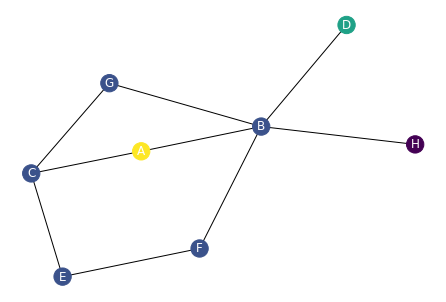

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.Graph()
G.add_edges_from(
    [('A', 'B'), ('A', 'C'), ('D', 'B'), ('E', 'C'), ('E', 'F'),
     ('B', 'H'), ('B', 'G'), ('B', 'F'), ('C', 'G')])

val_map = {'A': 1.0,
           'D': 0.5714285714285714,
           'H': 0.0}

values = [val_map.get(node, 0.25) for node in G.nodes()]

nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='white')
plt.show()

In [4]:
nx.__version__

'2.4'

Here is how to add attributes to the nodes and edges. We use a [well-known graph](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.social.karate_club_graph.html)

In [3]:
G = nx.karate_club_graph()
nx.number_of_nodes(G)

34

In [5]:
def seed(g):
    for node_id in g.nodes():
        g.nodes[node_id]['visited'] = 0
    for edge_id in g.edges():
        g.edges[edge_id]['traversed'] = 0
        
seed(G)

Ok, let's dig deeper into different graph types. 

## Graph types

Networks are categorized by the **degrees** of their nodes: The number of edges. The degree distribution (pdf) $P(k)$ of a network is then defined to be the fraction of nodes in the network with degree $k$. The same information is also sometimes presented in the form of a **cumulative degree distribution** (cdf): The fraction of nodes with degree *smaller* than $k$.

>**Definition**: The **degree** of a **node** in a network (sometimes referred to incorrectly as the *connectivity*) is the number of connections or edges the node has to other nodes. Thus if there are $n$ nodes in total in a network and $n_k$ of them have degree $k$, then the probability that a node has degree $n_k$ is $P(k) = n_k/n$.

## Constant number of neighbors

Here below is a random graph with degree 3 (meaning *every node has 3 neighbors*). Count them!

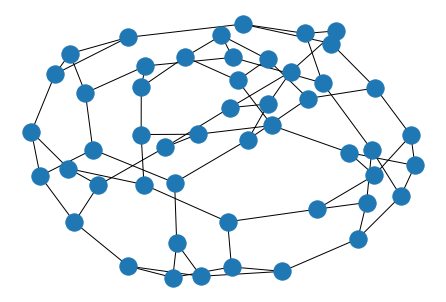

In [3]:
g = nx.random_regular_graph(3, 50)
nx.draw_spring(g)

## ER graphs

A simple and *beautiful* graph model is the [Erdős–Rényi graph](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) (ER) model, in which each of $n$ nodes is independently connected (or not) with probability $p$ (or $1 − p$).

This is what a 50-node Erdős–Rényi graph (where nodes now have a probabilistic degree *distribution*) looks like. Verify that nodes now have *varying* numbers of edges (neighbors):

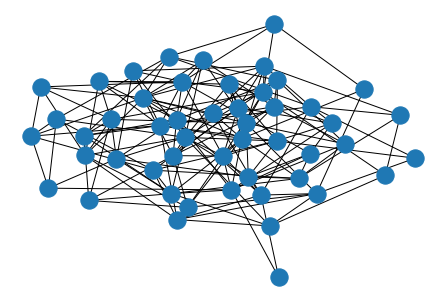

In [53]:
g = nx.erdos_renyi_graph(50, .15)
nx.draw_spring(g)

And this is what a 200-node Erdős–Rényi graph looks like:

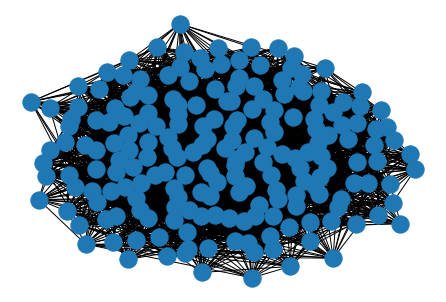

In [30]:
g = nx.erdos_renyi_graph(200, .15)
nx.draw_spring(g)

## Random graphs

A **random graph** on the other hand is one where each node has a **normal** probability of having a set number of neighbors. In other words, there is a specific degree (the **mean** of the normal pdf) that will occur much more often than others.

Making a random network is super-easy: Take $n$ nodes and $m$ pairs at random and place the edges between the randomly chosen nodes. Also, you could take $n$ nodes, compute a probability $p$ (from a normal distribution), and create an edge at random to another node.

The Erdős–Rényi graph is a special case where the probability for edge creation $p$ is fixed.

## Small World graphs

[A small world](https://en.wikipedia.org/wiki/ASmallWorld) was founded in 2004 as one of the first social networks (long before facebook), and is the leading invitation-only Travel and Lifestyle online community.

Duncan Watts and Steven Strogatz built a [small world graph model](https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model): a few random links in an otherwise structured graph make the
network a small world: the average shortest path is short.

Why did they build this?

 ER graphs do not have two important properties observed in many real-world networks:

- They do not generate **local clustering** and **triadic closures**. Instead, because they have a constant, random, and independent probability of two nodes being connected, ER graphs have a low clustering coefficient.
- They do not account for the formation of hubs. Formally, the degree distribution of ER graphs converges to a Poisson distribution, rather than a power law observed in many real-world, scale-free networks.

The Watts and Strogatz (WS) model was designed as the simplest possible model that addresses the first of the two limitations. It accounts for clustering while retaining the short average path lengths of the ER model. It does so by interpolating between a randomized structure close to ER graphs and a regular ring lattice. Consequently, the model is able to at least partially explain the "*small-world*" phenomena in a variety of networks, such as the power grid, neural network of C. elegans, networks of movie actors, 

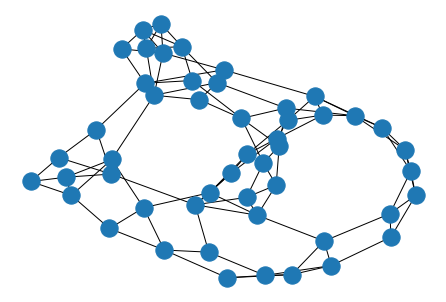

In [13]:
g = nx.watts_strogatz_graph(50, 5, .15)
nx.draw_spring(g)

# BA graphs

As for the second weakness of ER graphs, the [Barabási–Albert](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model) (BA) model is an algorithm for generating random scale-free networks using a preferential attachment mechanism. What this means is that some nodes are real attractors for all nodes, which want to create an edge with them.

Several natural and human-made systems, including the Internet, the world wide web, citation networks, and some social networks are thought to be approximately scale-free and certainly contain few nodes (called hubs) with unusually high degree as compared to the other nodes of the network. The BA model tries to explain the existence of such nodes in real networks. The algorithm is named for its inventors [Albert-László Barabási](https://en.wikipedia.org/wiki/Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si) and Réka Albert and is a special case of an earlier and more general model called Price's model. Laszlo is an acquaintance of mine.

The way to create a BA graph of n nodes is to grow it by attaching new nodes each with m edges that are preferentially attached to existing nodes with high degree. Not all nodes will have m neighbors. The initialization is a graph with with m nodes and no edges. Graph creation stops when you reach $n$ nodes.

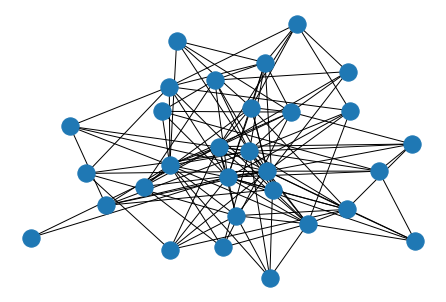

In [7]:
g = nx.barabasi_albert_graph(30, 5)
nx.draw_spring(g)

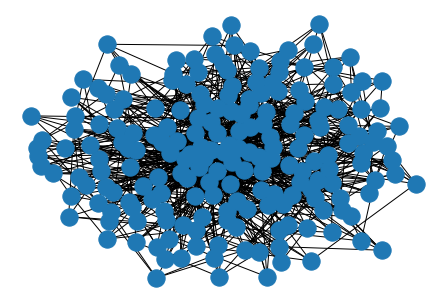

In [39]:
g = nx.barabasi_albert_graph(200, 5)
nx.draw_spring(g)

## Geometric graphs

A [geometric graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.geometric.random_geometric_graph.html) (GG) is grown in an interesting way: The graph model places n nodes uniformly at random in the unit cube. Two nodes are joined by an edge if the distance between the nodes is at most radius. Edges are determined using a `KDTree` when `SciPy` is available. This reduces the time complexity from O($4n^2$) to O($n$).

This is an interesting graph for us because it is the beginning of how we could randomly place people in a city. We will then modify this graph by clustering people into appartment buildings.

The graph is undirected and without self-loops. Each node has a node attribute `pos` that stores the position of that node in Euclidean space as provided by the `pos` API keyword argument or, if `pos` was not provided, as generated by `random_geometric_graph`.

In [2]:
import networkx as nx
from itertools import product
from random import choice, sample
import time as tm

dict_values([0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11])


(-0.05, 1.05)

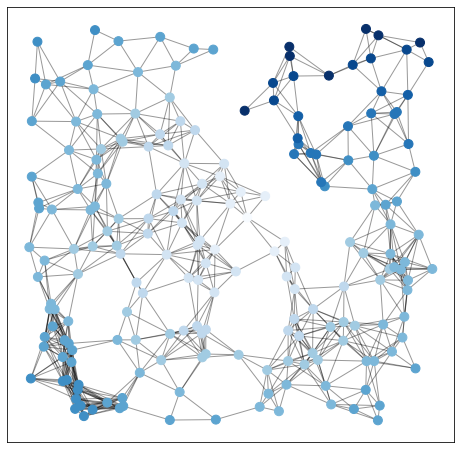

In [26]:
G=nx.random_geometric_graph(200, 0.125)
# position is stored as node attribute data for random_geometric_graph
pos=nx.get_node_attributes(G,'pos')

# find node near center (0.5,0.5)
dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

# color by path length from node near center
p=nx.single_source_shortest_path_length(G,ncenter)
#print(p.values())

plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G,pos,nodelist=[ncenter],alpha=0.4)
nx.draw_networkx_nodes(G,pos,nodelist=p.keys(),
                       node_size=80,
                       node_color=list(p.values()),
                       cmap=plt.cm.Blues)

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)

Here's one colored by distance from the center node (0.5, 0.5):

(-0.05, 1.05)

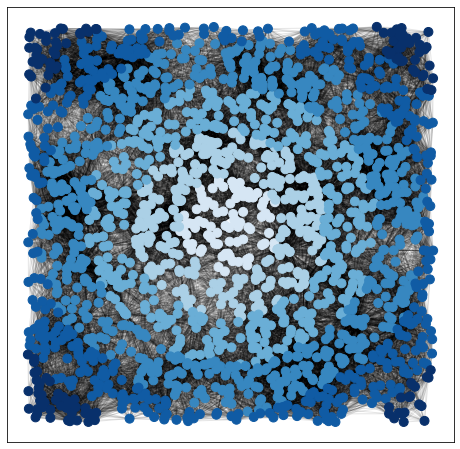

In [60]:
G=nx.random_geometric_graph(2000, 0.125)
# position is stored as node attribute data for random_geometric_graph
pos=nx.get_node_attributes(G,'pos')

# find node near center (0.5,0.5)
dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

# color by path length from node near center
p=nx.single_source_shortest_path_length(G,ncenter)
#print(p.values())

plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G,pos,nodelist=[ncenter],alpha=0.1)
nx.draw_networkx_nodes(G,pos,nodelist=p.keys(),
                       node_size=80,
                       node_color=list(p.values()),
                       cmap=plt.cm.Blues)

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)

How many neighbors per node?

In [80]:
list(G.neighbors(0))

[1714,
 468,
 623,
 1397,
 781,
 1049,
 287,
 1625,
 1447,
 1766,
 1859,
 1577,
 487,
 1626,
 1158,
 1482,
 221,
 1835,
 257,
 1284,
 1021,
 347,
 1636,
 180,
 1359,
 1941,
 690,
 1561,
 1684,
 784,
 92,
 359,
 465,
 293,
 36,
 677,
 1328,
 284,
 1253,
 1346,
 1046,
 1813,
 1486,
 1905,
 1746,
 1822,
 1212,
 1922,
 1824,
 485,
 805,
 1073]

In [73]:
neighs = []
for node_id in G.nodes():
     neighs.append(len(list(G.neighbors(node_id))))
','.join(str(_) for _ in neighs)

'52,79,97,82,67,108,92,84,91,87,90,105,78,110,90,86,54,87,68,56,107,113,33,82,50,86,102,94,42,112,72,79,81,90,115,79,63,56,102,99,100,89,53,112,97,95,63,94,93,103,83,107,48,104,78,92,91,99,47,100,84,97,39,51,97,38,86,64,84,106,87,69,59,60,57,96,68,73,89,108,27,105,103,103,105,70,100,95,92,90,90,49,45,108,93,90,101,85,115,54,103,77,107,74,83,97,80,68,102,93,96,103,45,47,79,113,101,104,72,71,99,108,75,86,103,84,60,87,111,89,91,100,74,107,112,76,91,68,99,104,102,101,99,115,84,106,98,114,80,99,83,95,100,102,77,89,51,82,113,117,105,100,61,96,108,100,111,99,102,78,87,102,93,79,111,84,49,107,112,105,49,106,89,114,108,99,105,100,109,93,65,102,80,67,110,91,114,112,107,51,89,94,90,99,91,93,93,98,97,61,117,108,54,90,95,103,92,94,104,96,109,58,109,108,53,113,103,86,101,83,94,103,98,88,94,84,78,50,69,113,88,96,118,117,108,92,96,53,117,47,93,60,106,63,75,93,50,47,88,108,78,49,95,93,110,73,103,91,86,100,100,101,54,98,49,103,82,68,106,98,86,104,116,108,51,109,96,70,92,69,115,106,105,66,104,65,98,88,10

In [74]:
sum(neighs)/2000.

88.319

A better metric is the **average degree** of the ***neighborhood*** of each node $i$:

$$k_{nn,i} = \frac{1}{|N(i)|}\, \sum_{j \in N(i)} k_j$$

where $N(i)$ are the neighbors of node $i$ and $k_j$ is the degree of node $j$ which belongs to $N(i)$.

In [83]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

take(20, nx.average_neighbor_degree(G).items())

[(0, 62.80769230769231),
 (1, 83.34177215189874),
 (2, 90.34020618556701),
 (3, 80.3170731707317),
 (4, 76.1044776119403),
 (5, 96.39814814814815),
 (6, 92.91304347826087),
 (7, 89.38095238095238),
 (8, 90.62637362637362),
 (9, 89.08045977011494),
 (10, 92.5111111111111),
 (11, 100.55238095238096),
 (12, 83.93589743589743),
 (13, 96.2090909090909),
 (14, 87.82222222222222),
 (15, 73.90697674418605),
 (16, 74.62962962962963),
 (17, 92.86206896551724),
 (18, 85.07352941176471),
 (19, 75.64285714285714)]

Average number of neighbors for the graph?

In [67]:
sum(nx.average_neighbor_degree(G).values()) / 2000.

90.03178275198977

Geometric graphs simulate GIS information well, so we'll pick geometric graphs for our simulations.

## Synthesizing graph shards

Let's start by creating graph shards whereby each shard grows its own graph. When edges are created between nodes inside the same shard, the edge is a regular edge. We'll then export a list of 10% of the remotest nodes on each graph (leveraging geometric graphs which have an imbued notion of distance) to a master controller (this notebook). 

The graph controller will then randomly create connections between the remote nodes of each shard, then communicate these to the shards, who will duplicate the connections of their remote nodes with new edges and new internal nodes tagged *external*.

We will then have a global distributed graph.

We will write a [Breadth-first search](https://en.wikipedia.org/wiki/Breadth-first_search) (BFS) for the shortest path between a node from one shard to another shard (most optimal kind of search for distributed shards). We will then adjust the sparsity of graph shards to have enough remote nodes to force a distributed BFS that actually spans many shards. We can then benchmark performance per number of shards spanned, which is statistically related to the sparsity of the shards. 

First, this is how we can add a node to a preexisting graph:

In [509]:
G = nx.random_geometric_graph(200, 0.125)
print(G.number_of_nodes())
G.add_node(200)
print(G.number_of_nodes())
print(G.number_of_edges())
G.add_edge(0, 200)
print(G.number_of_nodes())
print(G.number_of_edges())

200
201
886
201
887


Our nodes are simply indexed by monotonic integer sequences.

In [140]:
for node in G.nodes(): 
    print(node)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
1000


Adding an attribute to a node is straightforward:

In [145]:
G.nodes[1000]['pos'] = 10,10

Recovering the attribute as well. Note that geometric graphs are automatically tagged with the `pos` attribute:

In [146]:
distances = []
pos=nx.get_node_attributes(G,'pos')
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    distances.append((n,d))
print(distances)

[(0, 0.09891297672420143), (1, 0.15601160462295954), (2, 0.37783673408903223), (3, 0.18193900061325524), (4, 0.21569415299292616), (5, 0.40605590444230744), (6, 0.07464678626562539), (7, 0.1089907446237785), (8, 0.03511202582257569), (9, 0.24235496441543763), (10, 0.04798023275751918), (11, 0.1973570946123819), (12, 0.09298840161829022), (13, 0.05056096657055021), (14, 0.15242244252334508), (15, 0.3122609135630464), (16, 0.30731783268774027), (17, 0.03942356076755904), (18, 0.034467025308548095), (19, 0.25239338454081983), (20, 0.1662296932421159), (21, 0.10032103184192864), (22, 0.004268572083704327), (23, 0.30280440107864576), (24, 0.006578894993989412), (25, 0.4467163829791072), (26, 0.18101761330094168), (27, 0.1862162311247182), (28, 0.23512017466784133), (29, 0.22366706684255508), (30, 0.2847914575976835), (31, 0.3137124250659462), (32, 0.1352741097408754), (33, 0.08525612317738396), (34, 0.1570519425414735), (35, 0.3516568657591682), (36, 0.10791275191465269), (37, 0.16928368612

We're ready for our `shard` class:

## Graph shard prototype class

In [25]:
class Shard:
    def __init__(self, guid):
        self.guid_internal = guid

    def grow_graph(self, guid, nodes, p):
        self.guid = guid
        self.numnodes = nodes
        self.probaedge = p
        self.g = nx.random_geometric_graph(nodes, p)
        self.origpos = nx.get_node_attributes(self.g, 'pos')
        
        for node_id in self.g.nodes():
            self.g.nodes[node_id]['remote'] = None
        for edge_id in self.g.edges():
            self.g.edges[edge_id]['remote'] = None

        # returns the number of edges created and the node center					
        return self.g.number_of_edges(), self.node_center()[0]

    # temporary: For debugging!
    def nxgraph(self):
        return self.g
    
    def guid(self):
        return self.guid
        
    def nodes(self):
        return list(self.g.nodes)
    
    def edges(self):
        return list(self.g.edges)
    
    def numnodes(self):
        return self.g.number_of_nodes()
    
    def numedges(self):
        return self.g.number_of_edges()
    
    def node_attribute(self, node_id, attribute):
        try:
            return self.g.nodes[node_id][attribute]
        except:
            return "undefined!"

    def edge_attribute(self, edge_id, attribute):
        try:
            return self.g.edges[edge_id][attribute]
        except:
            return "undefined!"

    def nodes_with_attribute(self, attribute):
        try:
            an_attempt = self.g.nodes[0][attribute]
        except:
            return "The attribute " + attribute + " is not defined for all nodes!"

        return [(node_id, self.g.nodes[node_id][attribute]) for node_id in self.g.nodes]

    def edges_with_attribute(self, attribute):
        try:
            an_attempt = self.g.edges[0][attribute]
        except:
            return "The attribute " + attribute + " is not defined for all edges!"

        return [(edge_id, self.g.edges[edge_id][attribute]) for edge_id in self.g.edges]

    def nodes_with_attributes(self):
        return [(node_id, self.g.nodes[node_id]) for node_id in self.g.nodes]

    def edges_with_attributes(self):
        return [(edge_id, self.g.edges[edge_id]) for edge_id in self.g.edges]
    
    #input: [(ni,ne,x,y,shard,d), (), ..]
    def add_edge_external(self, nodes_and_pos):
        #print('-- shard ' + str(self.guid) + ': number of nodes ' + str(self.g.number_of_nodes()))
        num_new_nodes = len(nodes_and_pos)
        new_node_index = self.g.number_of_nodes()
        #print(new_node_index)
        for _ in nodes_and_pos:
            (ni, ne, x, y, shard, d) = _
            #print(ni, ne, x, y, shard, d)
            #print('-- shard ' + str(self.guid) + ': adding new node ' + str(new_node_index))
            self.g.add_node(new_node_index)
            self.g.nodes[new_node_index]['remote'] = shard, ne, d
            self.g.nodes[new_node_index]['pos'] = x, y
            self.g.add_edge(ni, new_node_index) 
            new_node_index +=1
        return "added " + str(num_new_nodes) + " new nodes representing copies of nodes on other shards, for a total of " + str(new_node_index) + " nodes."
    
    # returns all nodes of the graph that are copies of nodes that live on other shards
    # In other words, these "remote" nodes don't actually belong to this graph. They
    # are only used to create external edges
    def external_nodes(self):
        exnodes = []
        for node_id in self.g.nodes():
            label = self.g.nodes[node_id]['remote']
            if label is not None:
                exnodes.append((node_id, label))
        return exnodes
    
    # used to find the center of a geographic graph
    def node_center(self):
        # find node near center (0.5,0.5)
        dmin=1
        ncenter=0
        pos=nx.get_node_attributes(self.g,'pos')
        for n in pos:
            x,y=pos[n]
            d=(x-0.5)**2+(y-0.5)**2
            if d<dmin:
                ncenter=n
                dmin=d
        return ncenter, dmin
    
    # used to compute distance from graph center
    def nodes_distance_from_center(self):
        distances = []
        pos=nx.get_node_attributes(self.g,'pos')
        for n in pos:
            x,y=pos[n]
            d=(x-0.5)**2+(y-0.5)**2
            distances.append((n,d))
        return distances
    
    # used to locate the most far-away-from-center nodes in the graph.
    # These can then be connected to remote nodes on other graph shards
    def most_distant_internal_nodes(self, p=1, num=0):
        distances = []
        for n in self.origpos:
            x,y=self.origpos[n]
            d=(x-0.5)**2+(y-0.5)**2
            distances.append((n,round(d,2)))
        how_many = 0
        if p > 1: p = 1
        if 0 < num: 
            how_many = num
        else:
            how_many = int(self.numnodes * p)
        return(sorted(distances, key = lambda x: x[1])[-how_many:])
    
    def bfs_edges(self, source):
        return list(nx.bfs_edges(self.g, source))
    
    def bfs_tree(self, source):
        return list(nx.bfs_tree(self.g, source))
    
    def shortest_path(self, source, target):
        return nx.shortest_path(self.g, source=source, target=target)
    
    # does an internal BFS and returns ONLY external nodes that NEED TO BE traversed, since source node
    def bfs_remote_nodes_to_explore(self, source):
        exnodes = []
        tree = list(nx.bfs_tree(self.g, source))
        for n in tree:
            label = self.g.nodes[n]['remote']
            if label is not None:
                exnodes.append((n, label))
        return exnodes
    
    # returns internal nodes traversed, as well as external nodes that NEED TO BE traversed, single source node
    # DEPRECATED in favor of bfs_trees_with_remote_nodes() that takes in a list of starting nodes.
    def bfs_tree_with_remote_nodes(self, source):
        innodes = set()
        exnodes = []
        tree = list(nx.bfs_tree(self.g, source))
        for n in tree:
            label = self.g.nodes[n]['remote']
            if label is not None:
                exnodes.append((n, label))
            else:
                innodes.add(n)
        return innodes, exnodes
    
    # same as above but can submit multiple sources to BFS with
    # and external nodes to be investigated are grouped by shard
    # and returned. 
    # input format: sources is an iterable, either list or set
    # return format: {}, [(p, {}), (q, {}), ..]
    
    # Update: converting set output to list, to be able to JSONify
    #def bfs_trees_with_remote_nodes(self, sources, numshards):
    def bfs_trees_with_remote_nodes(self, num_shards, sources):
        innodes = set()
        extshards = []
        extnodes = [None]*num_shards
        for source in sources:
            tree = list(nx.bfs_tree(self.g, source))
            for n in tree:
                label = self.g.nodes[n]['remote']
                if label is not None:  #shard, ne, d
                    shard, extnode, distance = label
                    if shard not in extshards:
                        extshards.append(shard)
                    #print('*** ' + str(num_shards))
                    #print('*** ' + str(shard))
                    if extnodes[shard] is None:
                        extnodes[shard] = set()
                        extnodes[shard].add(extnode)
                    else:
                        extnodes[shard].add(extnode)
                else:
                    innodes.add(n)
                    
        extshards_and_nodes = []
        for i in range(0, num_shards):
            if i in extshards:
                extshards_and_nodes.append((i, list(extnodes[i])))
                
        return list(innodes), extshards_and_nodes

    # Given a URL and a port for its container, this method clones
    # the shard to neo4j using CYPHER	
    def create_neo_clone(url, port):
        return "not yet implemented!"

    # Given a URL and a port for its container, this method clones
    # the shard to janugraph using GREMLIN	
    def create_janus_clone(url, port):
        return "not yet implemented!"

    # BFS on neo4j clone
    def bfs_trees_with_remote_nodes_on_neo(self, sources):
        return "not yet implemented!"

    # BFS on janus clone
    def bfs_trees_with_remote_nodes_on_janus(self, sources):
        return "not yet implemented!"		

## Testing

Let's instantiate a shard:

In [27]:
s = Shard(0)
s.grow_graph(0, 200, 0.125)

(861, 162)

In [29]:
for node_id in s.nxgraph().nodes():
    label = s.g.nodes[node_id]['remote']
    if label is not None:
        print(node_id, label)

In [296]:
s.numedges()

933

In [297]:
s.node_center()

(180, 0.00051312028195485)

In [298]:
s.most_distant_internal_nodes(num=5)

[(117, 0.37657961116111716),
 (23, 0.38595537998669127),
 (112, 0.41068351606792364),
 (119, 0.4220800140204845),
 (176, 0.4231605666024332)]

Let's add an external node from shard \#5, 10 parsecs from shard 0:

In [299]:
s.add_edge_external([(180, 100, .1, .1, 5, 10)])

In [300]:
s.numedges()

934

Let's add another external node from shard \#9, 100 parsecs from shard 0:

In [301]:
s.add_edge_external([(90, 50, .1, .1, 9, 100)])

In [302]:
s.numedges()

935

Now I should have two external nodes in my shard:

In [303]:
s.external_nodes()

[(200, (5, 100, 10)), (201, (9, 50, 100))]

Let's do a BFS from the center node, hopefull reaching all the way to the external node (node 200):

In [257]:
s_edges_180 = list(nx.bfs_edges(s.graph(), 180))
print(s_edges_180)

[(180, 186), (180, 103), (180, 30), (180, 102), (180, 122), (180, 22), (180, 33), (180, 192), (180, 4), (180, 150), (180, 67), (180, 32), (180, 54), (180, 200), (186, 68), (186, 99), (186, 47), (103, 57), (30, 86), (30, 144), (30, 124), (30, 79), (30, 118), (30, 3), (30, 65), (30, 43), (30, 21), (30, 1), (102, 75), (102, 160), (102, 189), (102, 91), (22, 159), (33, 34), (150, 25), (67, 196), (67, 70), (47, 161), (57, 171), (57, 188), (118, 132), (1, 41), (75, 23), (75, 35), (75, 113), (34, 133), (34, 165), (196, 123), (196, 168), (171, 169), (188, 117), (132, 85), (132, 37), (41, 120), (41, 126), (41, 141), (41, 110), (165, 0), (165, 143), (165, 172), (165, 39), (168, 166), (169, 77), (117, 72), (85, 50), (37, 198), (120, 11), (120, 140), (0, 45), (0, 135), (0, 40), (0, 101), (143, 66), (77, 63), (77, 127), (77, 76), (77, 104), (72, 199), (72, 29), (72, 157), (140, 62), (45, 151), (40, 137), (40, 83), (40, 59), (101, 24), (101, 61), (101, 10), (63, 46), (63, 44), (127, 163), (104, 96),

In [258]:
s_tree_180 = list(nx.bfs_tree(s.graph(), 180))
print(s_tree_180)

[180, 186, 103, 30, 102, 122, 22, 33, 192, 4, 150, 67, 32, 54, 200, 68, 99, 47, 57, 86, 144, 124, 79, 118, 3, 65, 43, 21, 1, 75, 160, 189, 91, 159, 34, 25, 196, 70, 161, 171, 188, 132, 41, 23, 35, 113, 133, 165, 123, 168, 169, 117, 85, 37, 120, 126, 141, 110, 0, 143, 172, 39, 166, 77, 72, 50, 198, 11, 140, 45, 135, 40, 101, 66, 63, 127, 76, 104, 199, 29, 157, 62, 151, 137, 83, 59, 24, 61, 10, 46, 44, 163, 96, 154, 114, 28, 177, 107, 148, 58, 145, 182, 5, 121, 184, 15, 9, 19, 149, 38, 74, 13, 130, 51, 42, 195, 187, 26, 142, 119, 93, 6, 175, 53, 125, 89, 164, 109, 183, 193, 84, 106, 108, 71, 69, 90, 52, 190, 49, 88, 7, 31, 48, 139, 191, 115, 156, 97, 197, 80, 36, 105, 152, 173, 87, 158, 78, 56, 98, 17, 136, 147, 153, 94, 194, 170, 14, 112, 60, 111, 12, 129, 82, 179, 81, 176, 8, 181, 116, 92, 20, 134, 100, 18, 131, 2, 95, 162, 27, 55, 174, 167, 146, 138, 178, 128, 64, 16, 185, 73, 155]


In [260]:
s_tree_180 = s.bfs_tree(180)
print(s_tree_180)

[180, 186, 103, 30, 102, 122, 22, 33, 192, 4, 150, 67, 32, 54, 200, 68, 99, 47, 57, 86, 144, 124, 79, 118, 3, 65, 43, 21, 1, 75, 160, 189, 91, 159, 34, 25, 196, 70, 161, 171, 188, 132, 41, 23, 35, 113, 133, 165, 123, 168, 169, 117, 85, 37, 120, 126, 141, 110, 0, 143, 172, 39, 166, 77, 72, 50, 198, 11, 140, 45, 135, 40, 101, 66, 63, 127, 76, 104, 199, 29, 157, 62, 151, 137, 83, 59, 24, 61, 10, 46, 44, 163, 96, 154, 114, 28, 177, 107, 148, 58, 145, 182, 5, 121, 184, 15, 9, 19, 149, 38, 74, 13, 130, 51, 42, 195, 187, 26, 142, 119, 93, 6, 175, 53, 125, 89, 164, 109, 183, 193, 84, 106, 108, 71, 69, 90, 52, 190, 49, 88, 7, 31, 48, 139, 191, 115, 156, 97, 197, 80, 36, 105, 152, 173, 87, 158, 78, 56, 98, 17, 136, 147, 153, 94, 194, 170, 14, 112, 60, 111, 12, 129, 82, 179, 81, 176, 8, 181, 116, 92, 20, 134, 100, 18, 131, 2, 95, 162, 27, 55, 174, 167, 146, 138, 178, 128, 64, 16, 185, 73, 155]


In [261]:
200 in s_tree_180

True

Yay!

In [262]:
nx.shortest_path(s.graph(), source=180, target=200)

[180, 200]

In [263]:
s.bfs_remote_nodes_to_explore(180)

[(200, (5, 100, 10))]

## Distributed BFS with 2 shards

Ok, so far so good. Let's create two graphs, get each graph's farthest nodes, interconnect them, and do the *first phase* of a distributed BFS: Where we get on each shard the number of external nodes that still need to be traversed (that's called a **cross-cut**). 

In [304]:
s0 = Shard(0, 200, 0.125)
s1 = Shard(1, 200, 0.125)
print(s0.numedges())
print(s1.numedges())

810
871


In [305]:
s0_far = s0.most_distant_internal_nodes(num=20)
s0_far

[(170, 0.3151471778176515),
 (156, 0.3158712782381198),
 (142, 0.324453177596887),
 (111, 0.32773493600972703),
 (127, 0.3296357621315008),
 (144, 0.33891844058236054),
 (168, 0.35241593990613596),
 (8, 0.3588235345543754),
 (91, 0.36232750108145234),
 (124, 0.3628174130915506),
 (176, 0.3715625324233777),
 (161, 0.3753780555184987),
 (100, 0.37886135379528374),
 (29, 0.3905001869584481),
 (57, 0.41268313652842115),
 (113, 0.41390894721899246),
 (196, 0.41799212338571545),
 (46, 0.4238118298101232),
 (157, 0.43000359362670004),
 (56, 0.44480782002169694)]

In [306]:
s1_far = s1.most_distant_internal_nodes(num=20)
s1_far

[(143, 0.3055242431476651),
 (37, 0.30654955753502633),
 (99, 0.31905215043313656),
 (57, 0.3234586520354361),
 (145, 0.33310261638452887),
 (111, 0.3384782927827128),
 (64, 0.34439562728653716),
 (164, 0.35362954360956644),
 (188, 0.354495429047589),
 (198, 0.3605207454065701),
 (157, 0.37247759381676515),
 (176, 0.3730080585507133),
 (142, 0.37428514502884647),
 (72, 0.38215083121158827),
 (149, 0.38330575724822524),
 (18, 0.39463996505875926),
 (15, 0.3987915182923391),
 (66, 0.4105492395385409),
 (108, 0.4129361312472428),
 (48, 0.431437996363954)]

In [307]:
print([i for i,k in s1_far])

[143, 37, 99, 57, 145, 111, 64, 164, 188, 198, 157, 176, 142, 72, 149, 18, 15, 66, 108, 48]


In [308]:
# This is one combination
from itertools import product
from random import choice, sample
combination = (choice(s0_far), choice(s1_far))

# This is 20 combinations
pairings = sample(set(product([i for i,k in s0_far], [i for i,k in s1_far])), 20)
pairings

[(100, 142),
 (113, 142),
 (176, 99),
 (91, 188),
 (91, 143),
 (29, 149),
 (57, 15),
 (144, 15),
 (157, 108),
 (127, 145),
 (46, 143),
 (161, 15),
 (156, 188),
 (111, 188),
 (111, 57),
 (157, 145),
 (91, 142),
 (57, 198),
 (170, 188),
 (176, 176)]

Add remote nodes to `s0`:

In [309]:
for p in pairings:
    s0.add_edge_external([(p[0], p[1], .1, .1, 1, 10)])

Add remote nodes to `s1`:

In [310]:
for p in pairings:
    s1.add_edge_external([(p[1], p[0], .1, .1, 0, 10)])

In [311]:
s0.external_nodes()

[(200, (1, 142, 10)),
 (201, (1, 142, 10)),
 (202, (1, 99, 10)),
 (203, (1, 188, 10)),
 (204, (1, 143, 10)),
 (205, (1, 149, 10)),
 (206, (1, 15, 10)),
 (207, (1, 15, 10)),
 (208, (1, 108, 10)),
 (209, (1, 145, 10)),
 (210, (1, 143, 10)),
 (211, (1, 15, 10)),
 (212, (1, 188, 10)),
 (213, (1, 188, 10)),
 (214, (1, 57, 10)),
 (215, (1, 145, 10)),
 (216, (1, 142, 10)),
 (217, (1, 198, 10)),
 (218, (1, 188, 10)),
 (219, (1, 176, 10))]

In [312]:
s1.external_nodes()

[(200, (0, 100, 10)),
 (201, (0, 113, 10)),
 (202, (0, 176, 10)),
 (203, (0, 91, 10)),
 (204, (0, 91, 10)),
 (205, (0, 29, 10)),
 (206, (0, 57, 10)),
 (207, (0, 144, 10)),
 (208, (0, 157, 10)),
 (209, (0, 127, 10)),
 (210, (0, 46, 10)),
 (211, (0, 161, 10)),
 (212, (0, 156, 10)),
 (213, (0, 111, 10)),
 (214, (0, 111, 10)),
 (215, (0, 157, 10)),
 (216, (0, 91, 10)),
 (217, (0, 57, 10)),
 (218, (0, 170, 10)),
 (219, (0, 176, 10))]

Now let's do a BFS on `s0` to get the remote nodes that need to be traversed:

In [313]:
s0.node_center(), s1.node_center()

((180, 0.00051312028195485), (180, 0.00051312028195485))

In [314]:
s0.bfs_remote_nodes_to_explore(180)

[(209, (1, 145, 10)),
 (218, (1, 188, 10)),
 (205, (1, 149, 10)),
 (210, (1, 143, 10)),
 (206, (1, 15, 10)),
 (217, (1, 198, 10)),
 (201, (1, 142, 10)),
 (202, (1, 99, 10)),
 (219, (1, 176, 10)),
 (213, (1, 188, 10)),
 (214, (1, 57, 10)),
 (200, (1, 142, 10)),
 (207, (1, 15, 10)),
 (212, (1, 188, 10)),
 (203, (1, 188, 10)),
 (204, (1, 143, 10)),
 (216, (1, 142, 10)),
 (208, (1, 108, 10)),
 (215, (1, 145, 10)),
 (211, (1, 15, 10))]

In [317]:
s1.bfs_remote_nodes_to_explore(0)

[(202, (0, 176, 10)),
 (203, (0, 91, 10)),
 (212, (0, 156, 10)),
 (213, (0, 111, 10)),
 (218, (0, 170, 10)),
 (208, (0, 157, 10)),
 (204, (0, 91, 10)),
 (210, (0, 46, 10)),
 (214, (0, 111, 10)),
 (205, (0, 29, 10)),
 (217, (0, 57, 10)),
 (219, (0, 176, 10)),
 (200, (0, 100, 10)),
 (201, (0, 113, 10)),
 (216, (0, 91, 10)),
 (209, (0, 127, 10)),
 (215, (0, 157, 10)),
 (206, (0, 57, 10)),
 (207, (0, 144, 10)),
 (211, (0, 161, 10))]

Too many connections! Let's reduce the number of connections by tuning down the probability of edge creation from 0.125 to 0.08:

In [414]:
s0 = Shard(0, 200, 0.08)
s1 = Shard(1, 200, 0.08)
print(s0.numedges())
print(s1.numedges())

369
358


Ok, we've cut down on the number of edges by a factor 0f 2.

In [415]:
s0.node_center(), s1.node_center()

((180, 0.00051312028195485), (180, 0.00051312028195485))

In [416]:
s0_far = s0.most_distant_internal_nodes(num=10)
s0_far

[(40, 0.37492922760977443),
 (18, 0.3936980487285755),
 (191, 0.3978202683754951),
 (169, 0.3978894576206634),
 (186, 0.4080047775960801),
 (159, 0.41817868137406894),
 (185, 0.4318917479178622),
 (174, 0.4382137172451929),
 (26, 0.4474144287022653),
 (33, 0.4482681740095994)]

In [417]:
s1_far = s0.most_distant_internal_nodes(num=10)
s1_far

[(40, 0.37492922760977443),
 (18, 0.3936980487285755),
 (191, 0.3978202683754951),
 (169, 0.3978894576206634),
 (186, 0.4080047775960801),
 (159, 0.41817868137406894),
 (185, 0.4318917479178622),
 (174, 0.4382137172451929),
 (26, 0.4474144287022653),
 (33, 0.4482681740095994)]

In [418]:
pairings = sample(set(product([i for i,k in s0_far], [i for i,k in s1_far])), 15)
pairings

[(26, 169),
 (40, 40),
 (26, 185),
 (33, 186),
 (174, 185),
 (159, 26),
 (18, 159),
 (186, 18),
 (174, 33),
 (40, 18),
 (191, 174),
 (169, 191),
 (186, 33),
 (18, 191),
 (191, 33)]

In [419]:
for p in pairings:
    s0.add_edge_external([(p[0], p[1], .1, .1, 1, 10)])

In [420]:
for p in pairings:
    s1.add_edge_external([(p[1], p[0], .1, .1, 0, 10)])

In [421]:
s0.external_nodes()

[(200, (1, 169, 10)),
 (201, (1, 40, 10)),
 (202, (1, 185, 10)),
 (203, (1, 186, 10)),
 (204, (1, 185, 10)),
 (205, (1, 26, 10)),
 (206, (1, 159, 10)),
 (207, (1, 18, 10)),
 (208, (1, 33, 10)),
 (209, (1, 18, 10)),
 (210, (1, 174, 10)),
 (211, (1, 191, 10)),
 (212, (1, 33, 10)),
 (213, (1, 191, 10)),
 (214, (1, 33, 10))]

In [422]:
s1.external_nodes()

[(200, (0, 26, 10)),
 (201, (0, 40, 10)),
 (202, (0, 26, 10)),
 (203, (0, 33, 10)),
 (204, (0, 174, 10)),
 (205, (0, 159, 10)),
 (206, (0, 18, 10)),
 (207, (0, 186, 10)),
 (208, (0, 174, 10)),
 (209, (0, 40, 10)),
 (210, (0, 191, 10)),
 (211, (0, 169, 10)),
 (212, (0, 186, 10)),
 (213, (0, 18, 10)),
 (214, (0, 191, 10))]

In [423]:
s0.bfs_remote_nodes_to_explore(180)

[(206, (1, 159, 10)),
 (213, (1, 191, 10)),
 (207, (1, 18, 10)),
 (212, (1, 33, 10))]

In [424]:
s1.bfs_remote_nodes_to_explore(180)

[(201, (0, 40, 10)),
 (207, (0, 186, 10)),
 (209, (0, 40, 10)),
 (210, (0, 191, 10)),
 (200, (0, 26, 10)),
 (203, (0, 33, 10)),
 (205, (0, 159, 10)),
 (208, (0, 174, 10)),
 (212, (0, 186, 10)),
 (214, (0, 191, 10)),
 (202, (0, 26, 10)),
 (204, (0, 174, 10))]

So we see that with a 0.08 probability of an edge, with 15 remote connections, I get 4 external nodes in one shard and 12 external nodes in the other that need to be explored for a distributed BFS. That sounds about good for a prototype.

Now, for phase 2, I need to give to `s0` the `s1.bfs_remote_nodes_to_explore(180)`, and to `s1` the `s0.bfs_remote_nodes_to_explore(180)`.

And keep on iterating until there are no more external nodes to traverse.

## Distributed BFS with 16 shards

Now we're ready to prototype a distributed BFS with many shards, with the goal to see how many shard-to-shard operations may be required. Let's begin with 16 geographic shards arranged as a 4x4 grid.

In [568]:
s = []
sfar = []
for i in range(0, 16):
    s.append(Shard(i, 200, 0.08))
    sfar.append(s[i].most_distant_internal_nodes(num=16))

In [569]:
len(s)

16

In [570]:
len(sfar[0])

16

In [571]:
sfar[0]

[(189, 0.3034763011954752),
 (17, 0.3066085103828119),
 (60, 0.317120292730691),
 (161, 0.3179630457120519),
 (50, 0.318828966366751),
 (77, 0.3305068907261463),
 (76, 0.3438452601061894),
 (192, 0.3544887716979392),
 (73, 0.3627662787603272),
 (79, 0.38178480774343315),
 (14, 0.38563581799890156),
 (94, 0.3902433790380905),
 (46, 0.4129619651512366),
 (152, 0.4130494900473881),
 (193, 0.4558829006433236),
 (165, 0.46417034884278635)]

In [572]:
s[0].external_nodes()

[]

This would be one way to connect shard, *randomly*, but let's *not* do it this way.

Let's assume instead shards connect geographically in the 4 cardinal directions. So each shard connects to 4 other shards, and we wrap toroidally. Let's pick the 2nd toroidal wrap scheme below:

So the neighbors for each shard are the following:

In [573]:
sneigh = [None]*16
sneigh[0] = [1,4,3,12]
sneigh[1] = [2,5,0,13]
sneigh[2] = [3,6,1,14]
sneigh[3] = [0,7,2,15]
sneigh[4] = [5,8,7,0]
sneigh[5] = [6,9,4,1]
sneigh[6] = [7,10,5,2]
sneigh[7] = [4,11,6,3]
sneigh[8] = [9,12,11,4]
sneigh[9] = [10,13,8,5]
sneigh[10] = [11,14,9,6]
sneigh[11] = [8,15,10,7]
sneigh[12] = [13,0,15,8]
sneigh[13] = [14,1,12,9]
sneigh[14] = [15,2,13,10]
sneigh[15] = [12,3,14,11]

We now pair the *far* nodes for each shard to the *far* nodes of its neighbors. 

>**NOTE**: Note that we don't do this for all the shards, we just assign neighbors for shard 0 by making sure that the loop stays at p = 0 (`for p in range(0, 1):`). I don't want to interconnect the shards that much, yet. Just shard 0 with its neighbors.

>**NOTE**: Also note that ***we have a little bug here***: The 4th line below references an *unassigned* `i` variable. The last assignment for `i` was the line `for i in range(0, 16)` above, so the current value of `i` is 15. So we're actually assigning the neighbors of shard 15 to shard 0. I found this by backtracking, but i'll leave it alone here because all the prototyping below was completed with that assignment for the neighbors of shard 0. Not a big problem.

In [574]:
# geometric graph is undirected, so external edges need to be mirrored: a connection from a node on shard p to 
# a node on shard q needs to be accompanied by a connection from the node on shard q to the node on shard p
# Note that I allow pairings to be repeated (i.e. a node can connect to multiple nodes on distinct shard) but I only 
# connect two shards once, using paired_already as semaphore
paired_already = []
for p in range(0, 1):
    print(sneigh[1])
    for q in sneigh[i]:
        if (p,q) not in paired_already and (q,p) not in paired_already:
            pairings = sample(set(product([i for i,k in sfar[p]], [i for i,k in sfar[q]])), 8)
            print(pairings)
            for n in pairings:
                s[p].add_edge_external([(n[0], n[1], 1., 1., q, 1)])  #(ni, ne, x, y, shard, d)
                s[q].add_edge_external([(n[1], n[0], 1., 1., p, 1)])
            paired_already.append((p,q))

[2, 5, 0, 13]
[(76, 108), (46, 197), (60, 170), (50, 176), (193, 142), (79, 48), (152, 144), (60, 99)]
[(165, 99), (46, 183), (50, 188), (193, 38), (73, 183), (189, 69), (14, 147), (165, 158)]
[(46, 61), (79, 197), (60, 85), (94, 186), (192, 16), (192, 61), (152, 183), (165, 183)]
[(17, 92), (193, 172), (73, 134), (60, 112), (165, 194), (76, 85), (50, 1), (46, 93)]


For example, these are the external nodes on shard 0: The first number is the node ID on shard 0, and the second tuple consists of the shard ID on which that node really lives, the real ID of that node on that remote shard, and a geometric distance between the two shards (parsecs):

In [575]:
s[0].external_nodes()

[(200, (12, 108, 1)),
 (201, (12, 197, 1)),
 (202, (12, 170, 1)),
 (203, (12, 176, 1)),
 (204, (12, 142, 1)),
 (205, (12, 48, 1)),
 (206, (12, 144, 1)),
 (207, (12, 99, 1)),
 (208, (3, 99, 1)),
 (209, (3, 183, 1)),
 (210, (3, 188, 1)),
 (211, (3, 38, 1)),
 (212, (3, 183, 1)),
 (213, (3, 69, 1)),
 (214, (3, 147, 1)),
 (215, (3, 158, 1)),
 (216, (14, 61, 1)),
 (217, (14, 197, 1)),
 (218, (14, 85, 1)),
 (219, (14, 186, 1)),
 (220, (14, 16, 1)),
 (221, (14, 61, 1)),
 (222, (14, 183, 1)),
 (223, (14, 183, 1)),
 (224, (11, 92, 1)),
 (225, (11, 172, 1)),
 (226, (11, 134, 1)),
 (227, (11, 112, 1)),
 (228, (11, 194, 1)),
 (229, (11, 85, 1)),
 (230, (11, 1, 1)),
 (231, (11, 93, 1))]

>**NOTE**: Note that the neighbors for shard 0 are indeed set to shards 12, 3, 14, 11, which are actually the neighbors of shard 15 according to our toroidal wrap.

Let's start a BFS from the center of shard 0. Let's see how many cross-cuts it entails. We'll start the BFS from the geographic center of node 0:

In [576]:
s[0].node_center()

(72, 0.006457999491968201)

So these are the remote nodes that need to be explored in order to complete the distribted BFS that started on shard 0:

In [577]:
s[0].bfs_remote_nodes_to_explore(s[0].node_center()[0])

[]

In [565]:
s[3].bfs_remote_nodes_to_explore(161)

[]

Now i'm directed back to shard 0, node 33. Whas that traversed at all? I need to keep track of nodes traversed! This is where I leverage `bfs_tree_with_remote_nodes()`.

Let's start from scratch with new graph shards:

In [602]:
s = []
sfar = []
for i in range(0, 16):
    s.append(Shard(i, 200, 0.08))
    sfar.append(s[i].most_distant_internal_nodes(num=16))

In [603]:
sneigh = [None]*16
sneigh[0] = [1,4,3,12]
sneigh[1] = [2,5,0,13]
sneigh[2] = [3,6,1,14]
sneigh[3] = [0,7,2,15]
sneigh[4] = [5,8,7,0]
sneigh[5] = [6,9,4,1]
sneigh[6] = [7,10,5,2]
sneigh[7] = [4,11,6,3]
sneigh[8] = [9,12,11,4]
sneigh[9] = [10,13,8,5]
sneigh[10] = [11,14,9,6]
sneigh[11] = [8,15,10,7]
sneigh[12] = [13,0,15,8]
sneigh[13] = [14,1,12,9]
sneigh[14] = [15,2,13,10]
sneigh[15] = [12,3,14,11]

In [604]:
# geometric graph is undirected, so external nodes need to be mirrored: a connection from a node on shard p to 
# a node on shard q needs to be accompanied by a connection from the node on shard q to the node on shard p
# Note that I allow pairings to be repeated but I only connect two shards once, using paired_already as semaphore
paired_already = []
for p in range(0, 1):
    print(sneigh[1])
    for q in sneigh[i]:
        if (p,q) not in paired_already and (q,p) not in paired_already:
            pairings = sample(set(product([i for i,k in sfar[p]], [i for i,k in sfar[q]])), 8)
            print(pairings)
            for n in pairings:
                s[p].add_edge_external([(n[0], n[1], 1., 1., q, 1)])  #(ni, ne, x, y, shard, d)
                s[q].add_edge_external([(n[1], n[0], 1., 1., p, 1)])
            paired_already.append((p,q))

[2, 5, 0, 13]
[(36, 52), (49, 170), (105, 55), (178, 20), (9, 30), (136, 11), (136, 176), (59, 55)]
[(41, 88), (9, 100), (59, 65), (29, 100), (26, 125), (145, 176), (49, 125), (41, 176)]
[(178, 175), (145, 26), (49, 26), (36, 175), (9, 111), (49, 133), (36, 66), (9, 126)]
[(145, 191), (49, 29), (26, 97), (26, 52), (29, 130), (11, 130), (85, 108), (136, 29)]


In [605]:
s[0].bfs_remote_nodes_to_explore(s[0].node_center()[0])

[(207, (12, 55, 1)),
 (210, (3, 65, 1)),
 (200, (12, 52, 1)),
 (219, (14, 175, 1)),
 (222, (14, 66, 1)),
 (212, (3, 125, 1)),
 (226, (11, 97, 1)),
 (227, (11, 52, 1)),
 (208, (3, 88, 1)),
 (215, (3, 176, 1)),
 (229, (11, 130, 1)),
 (205, (12, 11, 1)),
 (206, (12, 176, 1)),
 (231, (11, 29, 1))]

In [608]:
straversed_internal = [None]*16
straversed_external = [None]*16
straversed_internal[0], straversed_external[0] = s[0].bfs_tree_with_remote_nodes(s[0].node_center()[0])
print(straversed_internal[0])
straversed_external[0]

{0, 1, 2, 3, 4, 129, 6, 7, 8, 135, 5, 139, 11, 136, 134, 144, 150, 22, 152, 153, 154, 26, 156, 157, 30, 159, 161, 163, 36, 37, 166, 39, 41, 171, 43, 172, 175, 47, 177, 50, 51, 179, 53, 180, 55, 185, 58, 59, 188, 189, 62, 187, 193, 66, 195, 67, 197, 70, 71, 72, 73, 199, 76, 77, 84, 86, 87, 92, 93, 96, 98, 99, 100, 103, 106, 114, 116, 117, 120, 124}


[(207, (12, 55, 1)),
 (210, (3, 65, 1)),
 (200, (12, 52, 1)),
 (219, (14, 175, 1)),
 (222, (14, 66, 1)),
 (212, (3, 125, 1)),
 (226, (11, 97, 1)),
 (227, (11, 52, 1)),
 (208, (3, 88, 1)),
 (215, (3, 176, 1)),
 (229, (11, 130, 1)),
 (205, (12, 11, 1)),
 (206, (12, 176, 1)),
 (231, (11, 29, 1))]

Now we code a complete cross-shard BFS that starts at the center node of shard 0. It's a serially distributed BFS here but one can easily see how that can become a parallel distributed BFS. 

What we're after is the number of required cross-cuts for a given level of shard graph sparsity.

In [41]:
# unfortunately, popitem() returns the *last* element in a dictionary
# faster than return list(mydictionary)[0], return next(iter(mydictionary.keys())), return list(mydictionary.keys())[0],  
# for key in mydictionary.keys(): return key, for key, v in mydictionary.items(): return key
def firstkey(mydictionary):
    for key in mydictionary:
        return key

In [44]:
def dbfs(nshards, begin_shard, verbose=False):

    time_spent_inside_shards_in_seconds = 0.
    time_spent_outside_shards_in_seconds = 0.

    cross_cuts_per_shard = dict()
    traversed_nodes = dict()
    shard_queue = dict()

    # start BFS at which shard, which nodes (note plural nodes bfs_trees_with_remote_nodes() API)?
    total_cross_cuts_required = 0
    begin_node = s[begin_shard].node_center()[0]
    shard_queue[begin_shard] = {begin_node} #(set with one element)

    # add the cross-cut for shard 'begin_shard', the starting point of the BFS.
    # Note we don't add it to the total total_cross_cuts_required
    cross_cuts_per_shard[begin_shard] = 1

    # while there are shards (and nodes on those shards) on the queue
    # Note: python 3.6 safeguards queue order (random beforehand)
    #debugging_p = True
    start_o = tm.time()
    while 0 < len(shard_queue):
    #while debugging_p:
        # pop first shard/nodes from the queue
        i = firstkey(shard_queue)
        ns = shard_queue.pop(i)

        # traverse the shard and get internal nodes visited by the BFS 
        # as well as external nodes and shards that still need to be visited
        if global_verbose:
            print("---> Traversing shard " + str(i) + ". Queue size: " + str(len(shard_queue)))
        if verbose:
            if i in traversed_nodes: 
                print("---> traversing shard " + str(i) + " again (" + str(cross_cuts_per_shard[i]) + ")!")
            else:
                print("---> traversing shard " + str(i))

        start = tm.time()
        #ins, exs = s[i].bfs_trees_with_remote_nodes(ns, num_shards)   #{}, [(p, {}), (q, {}), ..]
        ins, exs = s[i].bfs_trees_with_remote_nodes(nshards, ns)   #{}, [(p, {}), (q, {}), ..]
        end = tm.time()
        time_spent_inside_shards_in_seconds += end - start
        time_spent_outside_shards_in_seconds -= end - start

        # debugging
        if verbose:
            print("   BFS: internal nodes traversed: " + str(ins))
            print("   BFS: Need to additionally traverse following shards and their nodes: " + str(exs))
            print("        On these shards, only the following new nodes need to be visited:")
            for ex in exs:
                shard, nodes = ex

                if shard in traversed_nodes:
                    print("        On shard " + str(shard) +": Nodes " + str(set(nodes) - traversed_nodes[shard]))
                else:
                    print("        On shard " + str(shard) +": Nodes " + str(nodes))
            print("        ---------")


        # Action 1: Add internal nodes to the visited nodes per shard
        if i in traversed_nodes:
            traversed_nodes[i].update(set(ins)) # automatically discards duplicates
        else:
            traversed_nodes[i] = set(ins)


        # Action 2: if an external node that needs to be traversed hasn't 
        # already been traversed, schedule it for traversal and
        # increment the number of cross-cuts if that node hadn't
        # already been previously scheduled for traversal
        for ex in exs:      #[(p, {}), (q, {}), ..]
            (ss, nns) = ex  #(p, {})

            # nodes that have not already been traversed:
            real_nns = set(nns) - traversed_nodes[ss] if ss in traversed_nodes else set(nns)

            # if non-empty
            if real_nns:
                if ss in shard_queue:

                    # Shard ss is already spooled in the queue.
                    # Find queue entry and add the additional nodes to be visited only if they have not already been visited
                    # Note no new cross-cuts required at all, piggy-backing on already scheduled ones!
                    shard_queue[ss].update(real_nns)

                else:

                    # need new entry in shard queue, need to increment cross-cuts
                    shard_queue[ss] = real_nns
                    total_cross_cuts_required += 1
                    cross_cuts_per_shard[ss] = cross_cuts_per_shard[ss] + 1 if ss in cross_cuts_per_shard else 1

        # debugging
        if verbose:
            print("        shard queue = " + str(shard_queue))
            print()
            
            # If i don't do this I may exceed the allowed data rate and crash the hotebook!
            tm.sleep(0.1)
            
        #debugging_p = False

    if verbose:
        for i in range(0, nshards):
            if i not in traversed_nodes:
                print("        fyi, shard " + str(i) + " was never visited!")

    # num nodes visited
    num_nodes_visited = sum(
        [len(traversed_nodes[i]) for i in traversed_nodes]
    )
    
    end_o = tm.time()
    time_spent_outside_shards_in_seconds += end_o - start_o	
    return total_cross_cuts_required, num_nodes_visited, time_spent_inside_shards_in_seconds, time_spent_outside_shards_in_seconds


Unit-testing of `dbfs()` above revealed an optimization: *Instead* of returning external shard/node tuples to be visited like so, one by one: `[(12, 55), (3, 65), (12, 52), (14, 175), (14, 66), (3, 125), (11, 97), (11, 52), (3, 88), (3, 176), (11, 130), (12, 11), (12, 176), (11, 29)]`, let's *group* the tuples by shard, so that we can submit all external nodes to be BFS'ed to a shard in one fell swoop like so: `--- shard 3: Nodes {88, 65, 125, 176}, --- shard 11: Nodes {97, 130, 52, 29}, --- shard 12: Nodes {176, 11, 52, 55}, --- shard 14: Nodes {66, 175}`. You understand why this is going to be much faster, right? Instead of 14 total cross-cuts, we now only need 4 cross-cuts for the first iteration of the loop!

So we added the function `bfs_trees_with_remote_nodes()` to our `shard` class way above, which now takes in an array of source nodes to BFS from.

>**NOTE**: [Les Valiant](https://en.wikipedia.org/wiki/Leslie_Valiant) pioneered the use of communication properties of graphs for analysing computations. He is a recognized expert in efficient routing of communications in a multiprocessor system and showed that the overhead involved even in a sparse network need not grow with the size of the system. He won the Nevanlinna Prize in 1986, and the ACM Turing Award in 2010. He also invented the [Bulk Synchronous Parallel](https://en.wikipedia.org/wiki/Bulk_synchronous_parallel) bridging model for parallel algorithms, and the concept of *Barrier synchronisation*: When a process reaches a barrier, it waits until all other processes have reached the same barrier. We essentially model and optimize a barrier synchronization loop in our global BFS prototype below, where each iteration identifies new shards to be BFS-ed and adds them to a queue. It is easy pickings because we are not distributing any work. Instead, we run each shard query quite serially.

## Ready to interconnect all shards now

We can now complete the interconnection of all shards, pairing about 10% of the nodes of each shard with neighboring shards according to the toroidal wrapping scheme below. We also fix the little bug on the pairings.

We keep the probabily of edge creation at 0.08% for each shard to being with. We'll vary this later on, with the number of nodes per shard and the number of intra-shard neighbors.

We expect to have a much bigger number of cross-cuts now, since all our shards are now connected.

We also tally up at the end the total number of nodes visited to get an idea of how many nodes we actually need to traverse for a certain level of sparsity on the shards.

In [676]:
s = []
sfar = []
for i in range(0, 16):
    s.append(Shard(i, 200, 0.08))
    sfar.append(s[i].most_distant_internal_nodes(num=16))

In [677]:
sneigh = [None]*16
sneigh[0] = [1,4,3,12]
sneigh[1] = [2,5,0,13]
sneigh[2] = [3,6,1,14]
sneigh[3] = [0,7,2,15]
sneigh[4] = [5,8,7,0]
sneigh[5] = [6,9,4,1]
sneigh[6] = [7,10,5,2]
sneigh[7] = [4,11,6,3]
sneigh[8] = [9,12,11,4]
sneigh[9] = [10,13,8,5]
sneigh[10] = [11,14,9,6]
sneigh[11] = [8,15,10,7]
sneigh[12] = [13,0,15,8]
sneigh[13] = [14,1,12,9]
sneigh[14] = [15,2,13,10]
sneigh[15] = [12,3,14,11]

In [678]:
# geometric graph is undirected, so external nodes need to be mirrored: a connection from a node on shard p to 
# a node on shard q needs to be accompanied by a connection from the node on shard q to the node on shard p
# Note that I allow pairings to be repeated but I only connect two shards once, using paired_already as semaphore
paired_already = []
for p in range(0, 16):
    for q in sneigh[p]:
        if (p,q) not in paired_already and (q,p) not in paired_already:
            pairings = sample(set(product([i for i,k in sfar[p]], [i for i,k in sfar[q]])), 8)
            print(pairings)
            for n in pairings:
                s[p].add_edge_external([(n[0], n[1], 1., 1., q, 1)])  #(ni, ne, x, y, shard, d)
                s[q].add_edge_external([(n[1], n[0], 1., 1., p, 1)])
            paired_already.append((p,q))

[(171, 138), (58, 183), (147, 109), (196, 109), (69, 83), (123, 111), (123, 78), (43, 109)]
[(86, 3), (143, 2), (86, 49), (69, 3), (135, 90), (58, 48), (143, 3), (147, 90)]
[(119, 183), (196, 88), (123, 99), (43, 104), (143, 183), (137, 99), (58, 88), (171, 88)]
[(171, 10), (43, 146), (143, 146), (135, 136), (119, 58), (143, 97), (64, 16), (43, 97)]
[(111, 13), (177, 37), (177, 18), (78, 199), (194, 41), (109, 158), (138, 72), (119, 37)]
[(194, 46), (183, 27), (119, 27), (177, 195), (183, 173), (119, 28), (152, 28), (83, 57)]
[(78, 124), (194, 55), (163, 45), (177, 37), (138, 124), (111, 76), (78, 76), (185, 37)]
[(71, 175), (72, 187), (20, 183), (53, 58), (13, 96), (199, 187), (53, 88), (41, 187)]
[(196, 39), (91, 115), (41, 174), (158, 154), (158, 39), (53, 43), (155, 183), (72, 183)]
[(199, 144), (199, 143), (18, 130), (37, 88), (72, 185), (13, 143), (20, 143), (196, 172)]
[(58, 163), (137, 120), (58, 91), (158, 47), (88, 120), (88, 21), (137, 163), (137, 47)]
[(96, 1), (96, 78), (1

We run the sim below starting from the center of different shards (`begin_shard = ?`) and tabulate results at the end:

In [690]:
s[1].node_center()

(72, 0.006457999491968201)

In [689]:
ins, exs = s[1].bfs_trees_with_remote_nodes(16, [s[1].node_center()[0]], 16)
print(ins)
print(exs)

{133, 136, 142, 15, 144, 146, 22, 152, 26, 155, 28, 159, 31, 162, 42, 174, 51, 53, 181, 182, 184, 61, 189, 192, 194, 67, 196, 72, 74, 86, 88, 92, 93, 94, 96, 97, 100, 109, 114, 118, 122, 123, 124, 125, 126, 127}
[(0, {43, 147, 196}), (2, {41, 158}), (5, {28, 46}), (13, {55})]


## Graph density

A **dense** graph is generally [defined](https://en.wikipedia.org/wiki/Dense_graph) as a graph in which the number of edges is close to the maximal number of possible edges. We know from Euler that a planar graph with n vertices has at most 3n - 6 edges. So let's assume we are dealing with planar graphs since we're geometric graphs. That means that if the number of edges is about 3 times the number of nodes, we have ourselves a dense graph. So if we had 600 edges, we would have a dense planar graph. 

>**NOTE** For non-planar graphs, that figure is a lot higher, since we can have up to as many pairs as we can find in a collection of 200 nodes: That's *200 choose 2*, or $(^{200}_2)$, evaluated here below: About 20,000, or 30 times as many.

So what's a **sparse** graph? 

Graph **density** is usually defined as:

$$\frac{E}{V^2}$$

with $E$ the number of edges and $V$ the number of nodes. So if we say that a graph has density 1% (that sounds sparse, doesn't it?), that means that twice the number of edges is a hundredth of $V^2$. So for 200 nodes, that means about 400 edges. Which is what we have, here.

>**NOTE**: Not a big difference in edges for dense vs. sparse *planar* graphs! A much bigger one for *non-planar* graphs.

It seems a bit strange to me that 16 shards of sparse geometric graphs connected at their boundaries form a single spanning tree. I would have expected a few disconnected ones. 

In [735]:
200 * 199 / 2

19900.0

# The cost of sharding

BFS is preferred over Depth-First Search (DFS) for distributed searches (understandable why), and BFS is the basis of any kind of greedy graph exploration algorithm except for those based on linear algebra methods (involving matrix calculus). So I think it's a good representative model of the kinds of queries that might be submitted on the properties of nodes and edges of graph databases.

For sparse (at about 1% density, which is the figure that we were initially directed to plan around) planar geometric graphs, we find that 16 shards imply about 50 cross-cuts for a Breadth-First Search (BFS) across the entire graph. In other words, about a factor of 3 times the number of shards. 

Since cross-cuts are by orders of magnitude the most expensive operation on distributed shards, having a handle on the number of cross-cuts required per number of shards would constitute a good predictor of query performance on sharded graphs.

Let's see if we increase the number of shards, whether this factor grows linearly or exponentially. Let's almost double the number of shards to 36 (a square number, which allows us to keep a regular square grod of shards).

>**NOTE**: We can then also vary graph density as another potential benchmark. We could also generalize to non-planar graphs.

### Random inter-shard connection algorithm

First, we need a less manual algorithm for creating connections across shards than the topological one I picked, one that preferrably conserves the probability of edge creation for each shard. We could return to our candidate following cell \#572 in this notebook:

In [754]:
sneigh = []
for i in range(0, nshards):
    neigh = []
    while len(neigh) < num_far_nodes / 4:
        k = choice(s)
        if k.guid not in neigh:
            neigh.append(k.guid)
    sneigh.append(neigh)
print(sneigh)

[[10, 0, 3, 25], [14, 10, 13, 20], [16, 3, 7, 19], [1, 9, 30, 20], [26, 23, 0, 21], [1, 5, 21, 24], [15, 1, 26, 25], [28, 24, 6, 30], [0, 7, 29, 2], [29, 30, 24, 23], [5, 0, 21, 19], [24, 15, 17, 21], [12, 7, 21, 19], [25, 22, 3, 21], [10, 19, 3, 12], [25, 28, 24, 1], [28, 24, 3, 27], [2, 26, 21, 4], [1, 30, 26, 3], [19, 4, 0, 8], [1, 13, 28, 15], [2, 9, 0, 15], [24, 25, 5, 22], [8, 28, 5, 7], [23, 16, 26, 1], [18, 29, 14, 2], [9, 14, 20, 8], [19, 2, 21, 29], [10, 24, 19, 5], [29, 5, 11, 21], [29, 16, 12, 28], [4, 5, 6, 0]]


However, I prefer to stick with my toroidally wrapped planar graph so that I can compare apples to apples. So that means I need to stick with a number of graphs shards that are square. Here's a 7x7 one, with toroidal wrap:

How to find the neighbors?

For an $n^2$ total of shards, in general:
- neighbors(31) = $31 - 1, 31 + 1, 31 - 7, 31 + 7$. 

At the toroidal boundaries: 
- neighbors(03) = $3-1, 3+1, 3 +7, (3 - 7 = -4 = n^2 - 4 = 45)$
- neighbors(47) = $47 - 1, 47 + 1, 47 - 7, (47 + 7 = 5)$
- neighbors(27) = $27 -1, (27 - 7 + 1), 27 -7, 27 +7$
- neighbors(07) = $(07 - 1 + 7), 07 + 1, 07 - 7, 07 +7$
- neighbors(06) = $06 - 1, (06 + 1 - 7), (06 - 7 = -1 = n^2 - 1), 06 + 7$
- neighbors(48) = $48 -1, (48 - 7 + 1), 48 - 7, (48 + 7 = 6)$.

So we just do modulo arithmetic, except at the R edge where we subtract 7 first to get the right neighbor, and at the L edge where we add 7 to get the left neighbor.

Top row are the first n shards, bottom row are the last n shards, left edge are the +7 shards, and right edge are the -7 shards from the end. So here's the toroidal wrapped edges:

In [6]:
def tw_tr(n):
    return range(0, n)

def tw_br(n):
    return range(n**2 - 1, n**2 - 1 - n, -1)

def tw_lc(n):
    return range(0, n**2 - 1, n)

def tw_rc(n):
    return range(n**2 - 1, 0, -n)

(','.join(str(x) for x in tw_tr(7)), ','.join(str(x) for x in tw_br(7)), 
','.join(str(x) for x in tw_lc(7)), ','.join(str(x) for x in tw_rc(7)))

('0,1,2,3,4,5,6',
 '48,47,46,45,44,43,42',
 '0,7,14,21,28,35,42',
 '48,41,34,27,20,13,6')

And here is how to get the shard neighbors of any shard:

In [7]:
def tw_neigh(i, n):
    return (
        i-1 if i not in tw_lc(n) else i-1+n,
        i+1 if i not in tw_rc(n) else i+1-n,
        i-n if i not in tw_tr(n) else i-n+n**2,
        i+n if i not in tw_br(n) else i+n-n**2
    )

Let's test:

In [836]:
tw_neigh(31, 7), tw_neigh(3, 7), tw_neigh(47, 7), tw_neigh(27, 7), tw_neigh(7, 7), tw_neigh(6, 7), tw_neigh(48, 7)

((30, 32, 24, 38),
 (2, 4, 45, 10),
 (46, 48, 40, 5),
 (26, 21, 20, 34),
 (13, 8, 0, 14),
 (5, 0, 48, 13),
 (47, 42, 41, 6))

Let's verify our code for a 6 x 6 shard grid:

In [841]:
tw_neigh(29, 6), tw_neigh(30,6), tw_neigh(5, 6), tw_neigh(0,6)

((28, 24, 23, 35), (35, 31, 24, 0), (4, 0, 35, 11), (5, 1, 30, 6))

works! So now we can do the same planar toroidal wrap for any square shard number. 

In [9]:
import networkx as nx 
s = []
sfar = []
nshards = 36
nodes_per_shard = 200
p_edge_creation = 0.08
num_far_nodes_per_shard = 16    #this is the number of nodes in each shard that will be connected to another shard's nodes,
                                #potentially more than once

for i in range(0, nshards):
    sh = Shard(i)
    sh.grow_graph(i, nodes_per_shard, p_edge_creation)
    s.append(sh)
    sfar.append(s[i].most_distant_internal_nodes(num=num_far_nodes_per_shard))

In [11]:
import math as m

sneigh = [None]*nshards
for i in range(0, nshards):
    sneigh[i] = tw_neigh(i, int(m.sqrt(nshards)))

In [15]:
# geometric graph is undirected, so external nodes need to be mirrored: a connection from node n on shard p to 
# node m on shard q needs to be accompanied by a connection from node m on shard q to node n on shard p.
# Note that I allow pairings to be repeated but I only connect two shards once, using paired_already as semaphore
paired_already = []
for p in range(0, nshards):
    #print('*** shard ' + str(p))
    for q in sneigh[p]:
        if (p,q) not in paired_already and (q,p) not in paired_already:
            pairings = sample(set(product([i for i,k in sfar[p]], [i for i,k in sfar[q]])), 8)
            #print(pairings)
            for n in pairings:
                s[p].add_edge_external([(n[0], n[1], 1., 1., q, 1)])  #(ni, ne, x, y, shard, d)
                s[q].add_edge_external([(n[1], n[0], 1., 1., p, 1)])
            paired_already.append((p,q))

## 121 shards

Let's try 121 shards.

In [47]:
s = []
sfar = []
nshards = 121
nodes_per_shard = 200
p_edge_creation = 0.08
num_far_nodes_per_shard = 16  #this is the number of nodes in each shard that will be connected to another shard's nodes

for i in range(0, nshards):
    sh = Shard(i)
    sh.grow_graph(i, nodes_per_shard, p_edge_creation)
    s.append(sh)
    sfar.append(s[i].most_distant_internal_nodes(num=num_far_nodes_per_shard))

In [48]:
sneigh = [None]*nshards
for i in range(0, nshards):
    sneigh[i] = tw_neigh(i, int(m.sqrt(nshards)))

In [49]:
# geometric graph is undirected, so external nodes need to be mirrored: a connection from a node on shard p to 
# a node on shard q needs to be accompanied by a connection from the node on shard q to the node on shard p
# Note that I allow pairings to be repeated but I only connect two shards once, using paired_already as semaphore
paired_already = []
for p in range(0, nshards):
    for q in sneigh[p]:
        if (p,q) not in paired_already and (q,p) not in paired_already:
            pairings = sample(set(product([i for i,k in sfar[p]], [i for i,k in sfar[q]])), 8)
            #print(pairings)
            for n in pairings:
                s[p].add_edge_external([(n[0], n[1], 1., 1., q, 1)])  #(ni, ne, x, y, shard, d)
                s[q].add_edge_external([(n[1], n[0], 1., 1., p, 1)])
            paired_already.append((p,q))

In [50]:
len(s)

121

In [51]:
s[25].node_center()[0]

38

In [54]:
begin_shard=25
global_verbose = True
total_cross_cuts_required, num_nodes_visited, time_in, time_out = dbfs(nshards, begin_shard)

print("---> Distributed BFS on co-located shards complete!")
print('    ' + str(total_cross_cuts_required) + 
  ' cross-cuts required for BFS on ' + str(nshards) + ' shards starting from shard ' 
  + str(begin_shard) + ', node ' + str(s[begin_shard].node_center()[0]))
print('    Total number of nodes visited over total number of nodes in the entire graph: ' + 
  str(num_nodes_visited) + '/' +  str(nshards * nodes_per_shard))
print('    Seconds doing BFS inside shards: ' + str(time_in))
print('    Seconds doing overhead outside shards: ' + str(time_out))

---> Traversing shard 25. Queue size: 0
---> Traversing shard 24. Queue size: 1
---> Traversing shard 26. Queue size: 4
---> Traversing shard 13. Queue size: 6
---> Traversing shard 23. Queue size: 8
---> Traversing shard 25. Queue size: 9
---> Traversing shard 35. Queue size: 10
---> Traversing shard 15. Queue size: 10
---> Traversing shard 27. Queue size: 11
---> Traversing shard 37. Queue size: 12
---> Traversing shard 12. Queue size: 12
---> Traversing shard 14. Queue size: 15
---> Traversing shard 24. Queue size: 16
---> Traversing shard 22. Queue size: 16
---> Traversing shard 34. Queue size: 17
---> Traversing shard 26. Queue size: 17
---> Traversing shard 36. Queue size: 19
---> Traversing shard 46. Queue size: 19
---> Traversing shard 4. Queue size: 19
---> Traversing shard 16. Queue size: 19
---> Traversing shard 28. Queue size: 20
---> Traversing shard 38. Queue size: 21
---> Traversing shard 48. Queue size: 21
---> Traversing shard 1. Queue size: 21
---> Traversing shard 11

About 200 cross-cuts for 121 shards.

Let's move on to $50^2 = 2500$ shards.

In [62]:
s = []
sfar = []
nshards = 2500
nodes_per_shard = 200
p_edge_creation = 0.08
num_far_nodes_per_shard = 16  #this is the number of nodes in each shard that will be connected to another shard's nodes

for i in range(0, nshards):
    sh = Shard(i)
    sh.grow_graph(i, nodes_per_shard, p_edge_creation)
    s.append(sh)
    sfar.append(s[i].most_distant_internal_nodes(num=num_far_nodes_per_shard))

In [63]:
sneigh = [None]*nshards
for i in range(0, nshards):
    sneigh[i] = tw_neigh(i, int(m.sqrt(nshards)))

In [64]:
from itertools import product
from random import choice, sample

# geometric graph is undirected, so external nodes need to be mirrored: a connection from a node on shard p to 
# a node on shard q needs to be accompanied by a connection from the node on shard q to the node on shard p
# Note that I allow pairings to be repeated but I only connect two shards once, using paired_already as semaphore
paired_already = []
for p in range(0, nshards):
    for q in sneigh[p]:
        if (p,q) not in paired_already and (q,p) not in paired_already:
            pairings = sample(set(product([i for i,k in sfar[p]], [i for i,k in sfar[q]])), 8)
            #print(pairings)
            for n in pairings:
                s[p].add_edge_external([(n[0], n[1], 1., 1., q, 1)])  #(ni, ne, x, y, shard, d)
                s[q].add_edge_external([(n[1], n[0], 1., 1., p, 1)])
            paired_already.append((p,q))

In [67]:
begin_shard=99
total_cross_cuts_required, num_nodes_visited, time_in, time_out = dbfs(nshards, begin_shard)

print("---> Distributed BFS on co-located shards complete!")
print('    ' + str(total_cross_cuts_required) + 
  ' cross-cuts required for BFS on ' + str(nshards) + ' shards starting from shard ' 
  + str(begin_shard) + ', node ' + str(s[begin_shard].node_center()[0]))
print('    Total number of nodes visited over total number of nodes in the entire graph: ' + 
  str(num_nodes_visited) + '/' +  str(nshards * nodes_per_shard))
print('    Seconds doing BFS inside shards: ' + str(time_in))
print('    Seconds doing overhead outside shards: ' + str(time_out))

---> Traversing shard 99. Queue size: 0
---> Traversing shard 49. Queue size: 1
---> Traversing shard 149. Queue size: 4
---> Traversing shard 0. Queue size: 6
---> Traversing shard 48. Queue size: 9
---> Traversing shard 99. Queue size: 11
---> Traversing shard 2499. Queue size: 11
---> Traversing shard 100. Queue size: 11
---> Traversing shard 148. Queue size: 12
---> Traversing shard 199. Queue size: 13
---> Traversing shard 1. Queue size: 13
---> Traversing shard 49. Queue size: 16
---> Traversing shard 50. Queue size: 17
---> Traversing shard 2450. Queue size: 17
---> Traversing shard 47. Queue size: 18
---> Traversing shard 98. Queue size: 20
---> Traversing shard 2498. Queue size: 20
---> Traversing shard 149. Queue size: 20
---> Traversing shard 2449. Queue size: 20
---> Traversing shard 101. Queue size: 20
---> Traversing shard 150. Queue size: 21
---> Traversing shard 147. Queue size: 21
---> Traversing shard 198. Queue size: 22
---> Traversing shard 249. Queue size: 22
---> 

About 3,867 cross-cuts for 2,500 shards. Still pretty linear!

## Creating a neo4j clone

Let's create a neo4j clone from a nx shard:

In [30]:
s = []
sfar = []
nshards = 16
nodes_per_shard = 200
p_edge_creation = 0.08
num_far_nodes_per_shard = 16  #this is the number of nodes in each shard that will be connected to another shard's nodes

for i in range(0, nshards):
    sh = Shard(i)
    sh.grow_graph(i, nodes_per_shard, p_edge_creation)
    s.append(sh)
    sfar.append(s[i].most_distant_internal_nodes(num=num_far_nodes_per_shard))

In [31]:
import math as m

sneigh = [None]*nshards
for i in range(0, nshards):
    sneigh[i] = tw_neigh(i, int(m.sqrt(nshards)))

In [32]:
from itertools import product
from random import choice, sample

# geometric graph is undirected, so external nodes need to be mirrored: a connection from a node on shard p to 
# a node on shard q needs to be accompanied by a connection from the node on shard q to the node on shard p
# Note that I allow pairings to be repeated but I only connect two shards once, using paired_already as semaphore
paired_already = []
for p in range(0, nshards):
    for q in sneigh[p]:
        if (p,q) not in paired_already and (q,p) not in paired_already:
            pairings = sample(set(product([i for i,k in sfar[p]], [i for i,k in sfar[q]])), 8)
            #print(pairings)
            for n in pairings:
                s[p].add_edge_external([(n[0], n[1], 1., 1., q, 1)])  #(ni, ne, x, y, shard, d)
                s[q].add_edge_external([(n[1], n[0], 1., 1., p, 1)])
            paired_already.append((p,q))

In [92]:
s[0].nxgraph().nodes[200]

{'remote': (3, 163, 1), 'pos': (1.0, 1.0)}

In [100]:
#[(n, n[attribute]) for n in s[0].nxgraph().nodes]
[{node_id, a} 
 for node_id in s[0].nxgraph().nodes 
 for a in s[0].nxgraph().nodes[node_id]]

[{0, 'pos'},
 {0, 'remote'},
 {1, 'pos'},
 {1, 'remote'},
 {2, 'pos'},
 {2, 'remote'},
 {3, 'pos'},
 {3, 'remote'},
 {4, 'pos'},
 {4, 'remote'},
 {5, 'pos'},
 {5, 'remote'},
 {6, 'pos'},
 {6, 'remote'},
 {7, 'pos'},
 {7, 'remote'},
 {8, 'pos'},
 {8, 'remote'},
 {9, 'pos'},
 {9, 'remote'},
 {10, 'pos'},
 {10, 'remote'},
 {11, 'pos'},
 {11, 'remote'},
 {12, 'pos'},
 {12, 'remote'},
 {13, 'pos'},
 {13, 'remote'},
 {14, 'pos'},
 {14, 'remote'},
 {15, 'pos'},
 {15, 'remote'},
 {16, 'pos'},
 {16, 'remote'},
 {17, 'pos'},
 {17, 'remote'},
 {18, 'pos'},
 {18, 'remote'},
 {19, 'pos'},
 {19, 'remote'},
 {20, 'pos'},
 {20, 'remote'},
 {21, 'pos'},
 {21, 'remote'},
 {22, 'pos'},
 {22, 'remote'},
 {23, 'pos'},
 {23, 'remote'},
 {24, 'pos'},
 {24, 'remote'},
 {25, 'pos'},
 {25, 'remote'},
 {26, 'pos'},
 {26, 'remote'},
 {27, 'pos'},
 {27, 'remote'},
 {28, 'pos'},
 {28, 'remote'},
 {29, 'pos'},
 {29, 'remote'},
 {30, 'pos'},
 {30, 'remote'},
 {31, 'pos'},
 {31, 'remote'},
 {32, 'pos'},
 {32, 'remote'

In [105]:
[(node_id, s[0].nxgraph().nodes[node_id]) 
 for node_id in s[0].nxgraph().nodes]

[(0, {'pos': [0.19737194230278876, 0.3574274825018672], 'remote': None}),
 (1, {'pos': [0.24317275309420605, 0.16706150446669177], 'remote': None}),
 (2, {'pos': [0.40125547918648696, 0.7108431279595095], 'remote': None}),
 (3, {'pos': [0.6404224196724849, 0.6114357024877853], 'remote': None}),
 (4, {'pos': [0.4588446701725758, 0.28864120319362463], 'remote': None}),
 (5, {'pos': [0.33732899765738666, 0.5618014534756068], 'remote': None}),
 (6, {'pos': [0.4967931338027224, 0.4016873290130444], 'remote': None}),
 (7, {'pos': [0.032785393766905147, 0.22847116993076777], 'remote': None}),
 (8, {'pos': [0.40897395777155665, 0.0939898718328146], 'remote': None}),
 (9, {'pos': [0.6793585844215079, 0.8955254374618102], 'remote': None}),
 (10, {'pos': [0.21399914001405962, 0.10874275611090767], 'remote': None}),
 (11, {'pos': [0.9605353686609479, 0.9398551249920519], 'remote': None}),
 (12, {'pos': [0.9469793550226969, 0.9135701191352369], 'remote': None}),
 (13, {'pos': [0.5808239280269375, 0

In [106]:
[(node_id, s[0].nxgraph().nodes[node_id]['remote']) 
 for node_id in s[0].nxgraph().nodes]

[(0, None),
 (1, None),
 (2, None),
 (3, None),
 (4, None),
 (5, None),
 (6, None),
 (7, None),
 (8, None),
 (9, None),
 (10, None),
 (11, None),
 (12, None),
 (13, None),
 (14, None),
 (15, None),
 (16, None),
 (17, None),
 (18, None),
 (19, None),
 (20, None),
 (21, None),
 (22, None),
 (23, None),
 (24, None),
 (25, None),
 (26, None),
 (27, None),
 (28, None),
 (29, None),
 (30, None),
 (31, None),
 (32, None),
 (33, None),
 (34, None),
 (35, None),
 (36, None),
 (37, None),
 (38, None),
 (39, None),
 (40, None),
 (41, None),
 (42, None),
 (43, None),
 (44, None),
 (45, None),
 (46, None),
 (47, None),
 (48, None),
 (49, None),
 (50, None),
 (51, None),
 (52, None),
 (53, None),
 (54, None),
 (55, None),
 (56, None),
 (57, None),
 (58, None),
 (59, None),
 (60, None),
 (61, None),
 (62, None),
 (63, None),
 (64, None),
 (65, None),
 (66, None),
 (67, None),
 (68, None),
 (69, None),
 (70, None),
 (71, None),
 (72, None),
 (73, None),
 (74, None),
 (75, None),
 (76, None),
 (77, Non

In [110]:
[(edge_id, s[0].nxgraph().edges[edge_id]) for edge_id in s[0].nxgraph().edges]

[((0, 116), {'remote': None}),
 ((0, 80), {'remote': None}),
 ((1, 51), {'remote': None}),
 ((1, 95), {'remote': None}),
 ((1, 10), {'remote': None}),
 ((1, 180), {'remote': None}),
 ((1, 167), {'remote': None}),
 ((1, 50), {'remote': None}),
 ((1, 154), {'remote': None}),
 ((2, 142), {'remote': None}),
 ((2, 85), {'remote': None}),
 ((2, 93), {'remote': None}),
 ((3, 193), {'remote': None}),
 ((3, 109), {'remote': None}),
 ((3, 27), {'remote': None}),
 ((3, 99), {'remote': None}),
 ((4, 86), {'remote': None}),
 ((4, 110), {'remote': None}),
 ((4, 166), {'remote': None}),
 ((5, 62), {'remote': None}),
 ((5, 134), {'remote': None}),
 ((5, 120), {'remote': None}),
 ((5, 132), {'remote': None}),
 ((5, 65), {'remote': None}),
 ((6, 127), {'remote': None}),
 ((6, 182), {'remote': None}),
 ((6, 190), {'remote': None}),
 ((6, 110), {'remote': None}),
 ((6, 183), {'remote': None}),
 ((6, 148), {'remote': None}),
 ((6, 161), {'remote': None}),
 ((6, 198), {'remote': None}),
 ((7, 189), {'remote

In [112]:
def nodes_with_attribute(shard_id, attribute):
    try:
        an_attempt = s[shard_id].nxgraph().nodes[0][attribute]
    except:
        return "The attribute " + attribute + " is not defined for all nodes!"

    return [(node_id, s[shard_id].nxgraph().nodes[node_id][attribute]) for node_id in s[shard_id].nxgraph().nodes]

In [114]:
def myjson(j):
    # replace () and {} with [] as otherwise invalid JSON
    t = j.replace('(', '[')
    t = t.replace(')', ']')
    t = t.replace('{', '[')
    t = t.replace('}', ']')
    if not '[' == t[0]:
        t = '[' + t + ']'
    return t

In [117]:
nodes_with_attribute(0, 'remote')[0:10]

[(0, None),
 (1, None),
 (2, None),
 (3, None),
 (4, None),
 (5, None),
 (6, None),
 (7, None),
 (8, None),
 (9, None)]

In [120]:
import json as j
mydump = j.dumps(nodes_with_attribute(0, 'remote')).replace(' ', '')
mydump

'[[0,null],[1,null],[2,null],[3,null],[4,null],[5,null],[6,null],[7,null],[8,null],[9,null],[10,null],[11,null],[12,null],[13,null],[14,null],[15,null],[16,null],[17,null],[18,null],[19,null],[20,null],[21,null],[22,null],[23,null],[24,null],[25,null],[26,null],[27,null],[28,null],[29,null],[30,null],[31,null],[32,null],[33,null],[34,null],[35,null],[36,null],[37,null],[38,null],[39,null],[40,null],[41,null],[42,null],[43,null],[44,null],[45,null],[46,null],[47,null],[48,null],[49,null],[50,null],[51,null],[52,null],[53,null],[54,null],[55,null],[56,null],[57,null],[58,null],[59,null],[60,null],[61,null],[62,null],[63,null],[64,null],[65,null],[66,null],[67,null],[68,null],[69,null],[70,null],[71,null],[72,null],[73,null],[74,null],[75,null],[76,null],[77,null],[78,null],[79,null],[80,null],[81,null],[82,null],[83,null],[84,null],[85,null],[86,null],[87,null],[88,null],[89,null],[90,null],[91,null],[92,null],[93,null],[94,null],[95,null],[96,null],[97,null],[98,null],[99,null],[100,nul

In [121]:
j.loads(myjson(mydump))

[[0, None],
 [1, None],
 [2, None],
 [3, None],
 [4, None],
 [5, None],
 [6, None],
 [7, None],
 [8, None],
 [9, None],
 [10, None],
 [11, None],
 [12, None],
 [13, None],
 [14, None],
 [15, None],
 [16, None],
 [17, None],
 [18, None],
 [19, None],
 [20, None],
 [21, None],
 [22, None],
 [23, None],
 [24, None],
 [25, None],
 [26, None],
 [27, None],
 [28, None],
 [29, None],
 [30, None],
 [31, None],
 [32, None],
 [33, None],
 [34, None],
 [35, None],
 [36, None],
 [37, None],
 [38, None],
 [39, None],
 [40, None],
 [41, None],
 [42, None],
 [43, None],
 [44, None],
 [45, None],
 [46, None],
 [47, None],
 [48, None],
 [49, None],
 [50, None],
 [51, None],
 [52, None],
 [53, None],
 [54, None],
 [55, None],
 [56, None],
 [57, None],
 [58, None],
 [59, None],
 [60, None],
 [61, None],
 [62, None],
 [63, None],
 [64, None],
 [65, None],
 [66, None],
 [67, None],
 [68, None],
 [69, None],
 [70, None],
 [71, None],
 [72, None],
 [73, None],
 [74, None],
 [75, None],
 [76, None],
 [77, Non

In [122]:
snodes_and_attributes = j.dumps(nodes_with_attribute(0, 'remote')).replace(' ', '')
nodes_and_attributes = j.loads(myjson(snodes_and_attributes))
remote_nodes = dict()
for n,a in nodes_and_attributes:
    if not a is None:
        remote_nodes[n] = a
print(remote_nodes)

{200: [3, 163, 1], 201: [3, 28, 1], 202: [3, 148, 1], 203: [3, 8, 1], 204: [3, 148, 1], 205: [3, 167, 1], 206: [3, 49, 1], 207: [3, 156, 1], 208: [1, 169, 1], 209: [1, 97, 1], 210: [1, 180, 1], 211: [1, 186, 1], 212: [1, 193, 1], 213: [1, 193, 1], 214: [1, 132, 1], 215: [1, 60, 1], 216: [12, 157, 1], 217: [12, 156, 1], 218: [12, 95, 1], 219: [12, 63, 1], 220: [12, 190, 1], 221: [12, 166, 1], 222: [12, 95, 1], 223: [12, 157, 1], 224: [4, 101, 1], 225: [4, 0, 1], 226: [4, 161, 1], 227: [4, 84, 1], 228: [4, 161, 1], 229: [4, 176, 1], 230: [4, 183, 1], 231: [4, 84, 1]}


## Converting a networkX shard into a neo4j shard

Python driver for neo4j:
```(python)
pip install py2neo
```

In [44]:
from py2neo import Graph, Node, Relationship

In [ ]:
from py2neo import Node as nn
nn.

In [124]:
import json as j
def myints(seq):
    return list(map(lambda e: int(e), seq))
def myjson(j):
    # replace () and {} with [], and wrap with [] if not already, as otherwise invalid JSON
    t = j.replace('(', '[')
    t = t.replace(')', ']')
    t = t.replace('{', '[')
    t = t.replace('}', ']')
    if not '[' == t[0]:
        t = '[' + t + ']'
    return t
myints(j.loads(myjson('1,2,3,4,5,6')))

[1, 2, 3, 4, 5, 6]

In [59]:
# Given a URL and a port for a new container, this method clones
# the shard to neo4j using CYPHER	
def create_neo_clone(i, url):

    # login to neo server
    # Graph(host='192.168.99.100', auth=("neo4j", "test"))
    neo = Graph(host=url, auth=("neo4j", "test"))
    print(str(neo))

    # template:
    #n = Node("NNode", name="The_Prospector", id=6)
    #neo.create(n)
    #m = Node("NNode", name="The_Cowboy", id=7)
    #neo.create(m)
    #r = Relationship(n, "KNOWS", m, since=1999)
    #neo.create(r)

    # go through nodes and create neo nodes
    #for node_id in self.g.nodes():
    #    remote_attribute = self.g.nodes[node_id]['remote'] #None or (shard, ne, d)
    #    pos_attribute = self.g.nodes[node_id]['pos'] #x,y
    #    n = Node("NNode", name=str(node_id), id=node_id, remote=remote_attribute, pos=pos_attribute)

    # go through edges and create source and target nodes and relationship
    for source_node_id, target_node_id in s[i].edges():
        
        source_remote_attribute = s[i].nxgraph().nodes[source_node_id]['remote'] #None or (shard, ne, d)
        source_pos_attribute = s[i].nxgraph().nodes[target_node_id]['pos'] #x,y
        target_remote_attribute = s[i].nxgraph().nodes[target_node_id]['remote'] #None or (shard, ne, d)
        target_pos_attribute = s[i].nxgraph().nodes[target_node_id]['pos'] #x,y
        
        #if not source_remote_attribute is None:
        #    print("source(" + str(source_node_id) + ": " + str(source_remote_attribute))
            
        if not target_remote_attribute is None:
            print("source(" + str(source_node_id) + "), target(" + str(target_node_id) + "): " + str(target_remote_attribute))
            
        n = Node("NNode", name=str(source_node_id), id=source_node_id, remote=source_remote_attribute, 
                 pos=source_pos_attribute)
        m = Node("NNode", name=str(target_node_id), id=target_node_id, remote=target_remote_attribute, 
                 pos=target_pos_attribute)
        r = Relationship(n, "EDGE", m, since=1999)
        neo.create(n)
        neo.create(m)
        neo.create(r)

    # status
    for n,r,m in neo.run("MATCH (n)-[r]-(m) RETURN n,r,m;"):
        print (n,r,m)

    return s[i].nxgraph().number_of_nodes(), s[i].nxgraph().number_of_edges()

In [60]:
# docker run -p7474:7474 -p7687:7687 --env NEO4J_AUTH=neo4j/test neo4j:latest
create_neo_clone(0, '192.168.99.100')

<Graph database=<Database uri='bolt://192.168.99.100:7687' secure=False user_agent='py2neo/4.3.0 neobolt/1.7.16 Python/3.6.9-final-0 (win32)'> name='data'>
source(11), target(230): (4, 183, 1)
source(12), target(203): (3, 8, 1)
source(12), target(216): (12, 157, 1)
source(12), target(217): (12, 156, 1)
source(30), target(210): (1, 180, 1)
source(39), target(226): (4, 161, 1)
source(39), target(231): (4, 84, 1)
source(54), target(229): (4, 176, 1)
source(55), target(206): (3, 49, 1)
source(55), target(212): (1, 193, 1)
source(55), target(221): (12, 166, 1)
source(55), target(222): (12, 95, 1)
source(66), target(213): (1, 193, 1)
source(66), target(215): (1, 60, 1)
source(78), target(204): (3, 148, 1)
source(78), target(208): (1, 169, 1)
source(78), target(224): (4, 101, 1)
source(128), target(220): (12, 190, 1)
source(144), target(219): (12, 63, 1)
source(149), target(207): (3, 156, 1)
source(149), target(214): (1, 132, 1)
source(160), target(202): (3, 148, 1)
source(160), target(211): 

(232, 396)

In [61]:
def verify_neo_clone(url):
    neo = Graph(host=url, auth=("neo4j", "test"))
    print(neo.name)

    #result = []
    for n,r,m in neo.run("MATCH (n)-[r]-(m) RETURN n,r,m;"):
        print (n,r,m)
        #result.append(n+r+m)
    #return '\n',join(result)

In [62]:
verify_neo_clone('192.168.99.100')

data
(_1:NNode {id: 116, name: '116', pos: [0.18497421118367952, 0.2817262024279432]}) (0)-[:EDGE {since: 1999}]->(116) (_0:NNode {id: 0, name: '0', pos: [0.18497421118367952, 0.2817262024279432]})
(_0:NNode {id: 0, name: '0', pos: [0.18497421118367952, 0.2817262024279432]}) (0)-[:EDGE {since: 1999}]->(116) (_1:NNode {id: 116, name: '116', pos: [0.18497421118367952, 0.2817262024279432]})
(_3:NNode {id: 80, name: '80', pos: [0.22815056747633677, 0.40703839376093587]}) (0)-[:EDGE {since: 1999}]->(80) (_2:NNode {id: 0, name: '0', pos: [0.22815056747633677, 0.40703839376093587]})
(_2:NNode {id: 0, name: '0', pos: [0.22815056747633677, 0.40703839376093587]}) (0)-[:EDGE {since: 1999}]->(80) (_3:NNode {id: 80, name: '80', pos: [0.22815056747633677, 0.40703839376093587]})
(_5:NNode {id: 51, name: '51', pos: [0.29761165449047, 0.1942159839283787]}) (1)-[:EDGE {since: 1999}]->(51) (_4:NNode {id: 1, name: '1', pos: [0.29761165449047, 0.1942159839283787]})
(_4:NNode {id: 1, name: '1', pos: [0.2976

Don't run this below unless you *want* to clear the data!

In [ ]:
def clear_neo_clone(url, port):
    neo = Graph(host=url, auth=("neo4j", "test"))
    print(neo.name)

    # option 1
    #neo.run("MATCH ()-[r]-() DELETE r;")
    #neo.run("MATCH (n) DELETE n;")
    
    # option 2
    neo.run("MATCH (n) OPTIONAL MATCH (n)-[r]-() WITH n,r LIMIT 50000 DELETE n,r RETURN count(n) as deletedNodesCount;")

# Converting a networkX shard into a janus shard

Let's create a janus clone from a nx shard.
```(python)
docker run -it -p 8182:8182 janusgraph/janusgraph
```

Gremlin-Python is designed to connect to a “server” that is hosting a TinkerPop-enabled graph system.

*Don't* do this, it creates tons of problems:
```(python)
pip install gremlinpython --user
```

These are some of the problems:
You'd have to do this, which leaves you with a mized installation of the version of `torando` that gremlinpython wants (5.5.1) and the defautl anaconda version which is 6.0
```(python)
pip install tornado
```

`Tornado` is a Python web framework and asynchronous networking library, originally developed at FriendFeed. By using non-blocking network I/O, Tornado can scale to tens of thousands of open connections, making it ideal for long polling, WebSockets, and other applications that require a long-lived connection to each user.

Install *this* instead:
```(python)
pip install gremlinpython==3.4.6
```

Example use:
```(python)
>>> g.V().both()[1:3].toList()
[v[2], v[4]]
>>> g.V().both()[1].toList()
[v[2]]
>>> g.V().both().name.toList()
[lop, vadas, josh, marko, marko, josh, peter, ripple, lop, marko, josh, lop]
```

From this [URL](http://tinkerpop.apache.org/docs/3.4.6/recipes/), the following remark about large janus graphs:

### Large graphs
Large graphs in TinkerPop require distributed processing by SparkGraphComputer to get results in a reasonable time (OLAP approach). This means that the graph must be available as HadoopGraph (third party TinkerPop implementations often allow to make a graph available as an HadoopGraph by providing an Hadoop InputFormat). Running the connectedComponent()-step on an HadoopGraph works the same as for a small graph, provided that SparkGraphComputer is specified as the graph computer, either with the gremlin.hadoop.defaultGraphComputer property or as part of the withComputer()-step.

Scalability of the the connectedComponent()-step with SparkGraphComputer is high, but note that:

The graph should fit in the memory of the Spark cluster to allow the VertexProgram to run its cycles without spilling intermediate results to disk and loosing most of the gains from the distributed processing.

As discussed for small graphs, the BSP algorithm does not play well with graphs having a large shortest path between any pair of vertices. Overcoming this limitation is still a subject of [academic research](http://www.vldb.org/pvldb/vol7/p1821-yan.pdf).

In [80]:
from gremlin_python import statics
from gremlin_python.structure.graph import Graph as jGraph
from gremlin_python.process.graph_traversal import __
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection

# Create a GraphTraversalSource which is the basis for all Gremlin traversals:
#graph = jGraph()
#connection = DriverRemoteConnection('ws://localhost:8182/gremlin', 'g')
# The connection should be closed on shut down to close open connections with connection.close()
#g = graph.traversal().withRemote(connection)
# Reuse 'g' across the application

### Problems if you don't install the right version of gremlingpython

Ok, `tornado` is a friekin' pain in the @55.. I need to specify an old version to accomodate `gremlinpython`!
```(python)
pip install tornado==4.4.1
```

This is how I know:

In [83]:
import tornado

But now I have to live with the following warts:

## Creating a janus clone

In [84]:
# Given a URL and a port for a new container, this method clones
# the shard with index i to janus using GREMLIN
# https://github.com/nedlowe/gremlin-python-example/blob/master/app.py
# http://tinkerpop.apache.org/
# https://github.com/opencypher/cypher-for-gremlin
# http://tinkerpop.apache.org/docs/3.4.6/tutorials/getting-started/
def create_janus_clone(i, url):

    # login to janus server
    janus = jGraph()
    #connstring = 'wss://192.168.99.100:8182/gremlin'
    connstring = 'ws://' + url + ':8182/gremlin'
    j = janus.traversal().withRemote(DriverRemoteConnection(connstring, 'j'))

    # template:
    #n = Node("NNode", name="The_Prospector", id=6)
    #neo.create(n)
    #m = Node("NNode", name="The_Cowboy", id=7)
    #neo.create(m)
    #r = Relationship(n, "KNOWS", m, since=1999)
    #neo.create(r)

    # go through nodes and create neo nodes
    #for node_id in self.g.nodes():
    #    remote_attribute = self.g.nodes[node_id]['remote'] #None or (shard, ne, d)
    #    pos_attribute = self.g.nodes[node_id]['pos'] #x,y
    #    n = Node("NNode", name=str(node_id), id=node_id, remote=remote_attribute, pos=pos_attribute)

    # go through edges and create source and target nodes and relationship
    for source_node_id, target_node_id in s[i].edges():
        
        source_remote_attribute = s[i].nxgraph().nodes[source_node_id]['remote'] #None or (shard, ne, d)
        source_pos_attribute = s[i].nxgraph().nodes[target_node_id]['pos'] #x,y
        target_remote_attribute = s[i].nxgraph().nodes[target_node_id]['remote'] #None or (shard, ne, d)
        target_pos_attribute = s[i].nxgraph().nodes[target_node_id]['pos'] #x,y
        
        #if not source_remote_attribute is None:
        #    print("source(" + str(source_node_id) + ": " + str(source_remote_attribute))
            
        if not target_remote_attribute is None:
            print("source(" + str(source_node_id) + "), target(" + str(target_node_id) + "): " + str(target_remote_attribute))

        # a = g.addV()
        # b = g.addV()
        # a.addE('foo').to(b).toList()
        # v1 = g.addV("person").property(id, 1).property("name", "marko").property("age", 29).next()
        # g.addE("created").from(v1).to(v2).property(id, 9).property("weight", 0.4)
        
        n = j.addV('NNode').property(id, source_node_id).property('remote', source_remote_attribute).property('pos', source_pos_attribute).next()
        #j.V(n).property('remote', source_remote_attribute).next()
        #j.V(n).property('pos', source_pos_attribute).next()
        
        m = j.addV('NNode').property(id, target_node_id).property('remote', target_remote_attribute).property('pos', target_pos_attribute).next()
        #j.V(m).property('remote', target_remote_attribute).next()
        #j.V(m).property('pos', target_pos_attribute).next()
        
        j.V(n).addE('edge').to(m).property('since', 1999).next()
        # groovy: j.addE('edge').from(n).to(m).property('since', 1999)
        # g.V(Bindings.of('id',v1)).addE('knows').to(v2).property('weight',0.75).iterate()


    # status
    #for n,r,m in neo.run("MATCH (n)-[r]-(m) RETURN n,r,m;"):
    #    print (n,r,m)

    return s[i].nxgraph().number_of_nodes(), s[i].nxgraph().number_of_edges()

https://github.com/pusher/pusher-http-python/issues/115

looks like the solution is to use `tornado.concurrent.Future`:

In `d:\Anaconda3.5.1\lib\site-packages\tornado\iostream.py`:

```(python)
#~dk
#from tornado.concurrent import TracebackFuture
from tornado.concurrent import Future
```

In [85]:
# j.V().drop().iterate()
create_janus_clone(0, '192.168.99.100')

Exception: Please install Tornado or passcustom transport factory

Can'r really do this in an Anaconda notebook because Anaconda comes preloaded with Torndao 6.0. So i'm going to have to run this with a plain vanilla python 3.6 distro, where I can install the versions I want!

>Continued in file jg_g_shard.py

In [ ]:
# https://groups.google.com/forum/#!topic/gremlin-users/90IY6QMp4YQ
def return_graph(traversal)
    # Get all the path from root to leaves which has at least one of the vertex from a vertexList.
    #g.V(1).repeat(out()).until(outE().count().is(0)).path().filter(unfold().is(within(vertexList)))
    
    # Get all such paths, where path contains at least half of the vertices from vertexList
    #g.V(1).repeat(out()).until(outE().count().is(0)).path().filter(unfold().is(within(vertexList)).count().is(gte(vertexList.size() / 2)))
    
    # moi
    return traversal.V(0).repeat(out()).until(outE().count().is(0)).path()

## BFS on neo4j shard:

Wow, ***unimplemented***! See [here](https://stackoverflow.com/questions/47013872/tinkerpop-gremlin-depth-first-search-order). Not even available in their [common recipes](https://tinkerpop.apache.org/docs/current/recipes/)!

Other relevant URLs:
- https://github.com/tinkerpop/gremlin/wiki/Depth-First-vs.-Breadth-First


In [ ]:
def janus_bfs_1(sourcenode):
    nodes = j.withSack(1.0).V(sourcenode).repeat(__.outE('edge').sack(Operator.mult).by('since')
                                                              .inV()).until(__.sack().is_(P.lt(threshold))).emit() \
            .as_('b').sack().as_('a').select('a', 'b').toList()

In [ ]:
def janus_bfs_2(sourcenode):
    g.v(sourcenode).outE('edge').gather.scatter.inV.gather.scatter.inE('edge').gather.scatter.outV.gather.scatter

In [ ]:
# https://stackoverflow.com/questions/57090309/how-do-i-get-all-the-edges-associated-vertices-and-the-respective-id-label-an
def janus_bfs_3(sourcenode):
    g.V().bothE().otherV().limit(2).path().by(__.valueMap(true))

## Valuable information
This info is for when you run out of disk space because your docker toolbox VM is chock-full of dangling containers and images:

- https://zoomicon.wordpress.com/2015/04/18/howto-delete-all-nodes-and-relationships-from-neo4j-graph-database/
- https://neo4j.com/developer/kb/how-do-recover-from-no-space-left-on-device/
- https://success.docker.com/article/no-space-left-on-device-error
- https://stackoverflow.com/questions/55736572/docker-toolbox-storage-on-windows
- https://docs.docker.com/machine/reference/ssh/
- https://stackoverflow.com/questions/30330442/how-to-ssh-into-docker-machine-virtualbox-instance

```(python)
docker system prune --all # this deletes all dangling containers and images!
```

To see the log files:
```(python)
docker-machine ssh default
sudo du -d1 -h /var/lib/docker/containers | sort
cat /dev/null > /var/lib/docker/containers/container_id/container_log_name
sudo sh -c "cat /dev/null > /var/lib/docker/containers/container_id/container_log_name"
```

In [63]:
#clear_neo_clone('192.168.99.100', 7474)

## RDF

In [ ]:
from rdflib.extras.external_graph_libs import *
from rdflib import Graph, URIRef, Literal
import networkx as nx

graph = Graph()
graph.parse('Airports-with-labels.nt', format='nt')
nx_graph = rdflib_to_networkx_multidigraph(graph)
nx.write_graphml(nx_graph,'example_airport.graphml')

## References

[Measuring Graph Analytics Performance, Intel Corporation, 2020](https://www.codeproject.com/Articles/5263087/Measuring-Graph-Analytics-Performance)